## Step 1: Imports and Setup

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

## Step 2: Data Preparation


In [2]:
# prepare datasets
trainset, valset = prepare_datasets(dataset_name, data_root, 
                                    normalize=normalize_data, 
                                    precalculated_stats=(0.4733640253543854, 0.21108488738536835))

using precalculated stats - mean: 0.4733640253543854, std: 0.21108488738536835
Files already downloaded and verified
Files already downloaded and verified
after normalization: mean: -4.796001576323761e-06, std: 1.000001072883606


## Step 3: Define CNN Architectures

### Model 1: Simple CNN


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # output: 32x32x32
        self.relu1 = nn.ReLU()
        # output size: 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2)
        # output size: 32x16x16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # output: 64x16x16
        self.relu2 = nn.ReLU()
        # output size: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output size: 64x8x8

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # conv1
        x = self.conv1(x)  # input: [batch, 3, 32,32], output: [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]
        
        # conv2
        x = self.conv2(x)  # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]
        
        x = x.view(x.size(0), -1)  # [batch, 64*8*8]
        x = self.fc1(x)  # [batch,128]
        x = self.relu3(x)  # [batch,128]
        x = self.fc2(x)  # [batch,10]
        
        return x

In [4]:
class SuperSimpleNN(nn.Module):

    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

## Step 4: Initialize and Train Models

### Training Function

In [5]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=3e-4)  # weight_decay=1e-4
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=None,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=True,
        seed=42,
        # strict_reproducibility=True
        # wandb_project="cifar10",
        # wandb_entity="futuregoose",
        # sweep=True,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

### Train Model 1: Simple CNN

In [6]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
model0 = SimpleCNN()
# trainer0 = train_model(model0, "SimpleCNN", num_epochs=5)

### Train Model 2: ResNet-20

[epoch 01] train loss: 1.6518 | val loss: 1.4055 | accuracy: 47.78%
Validation loss decreased (inf --> 1.4055). Saving model.
[epoch 02] train loss: 1.2491 | val loss: 1.2197 | accuracy: 55.84%
Validation loss decreased (1.4055 --> 1.2197). Saving model.
[epoch 03] train loss: 1.0567 | val loss: 1.1016 | accuracy: 60.89%
Validation loss decreased (1.2197 --> 1.1016). Saving model.
[epoch 04] train loss: 0.9205 | val loss: 1.0377 | accuracy: 63.36%
Validation loss decreased (1.1016 --> 1.0377). Saving model.
[epoch 05] train loss: 0.8195 | val loss: 0.9274 | accuracy: 67.61%
Validation loss decreased (1.0377 --> 0.9274). Saving model.
[epoch 06] train loss: 0.7327 | val loss: 0.9331 | accuracy: 68.27%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 0.6598 | val loss: 0.9435 | accuracy: 68.19%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 0.5857 | val loss: 0.8607 | accuracy: 70.59%
Validation loss decreased (0.9274 --> 0.8607). Saving model.
[epoch 09] train loss: 0.

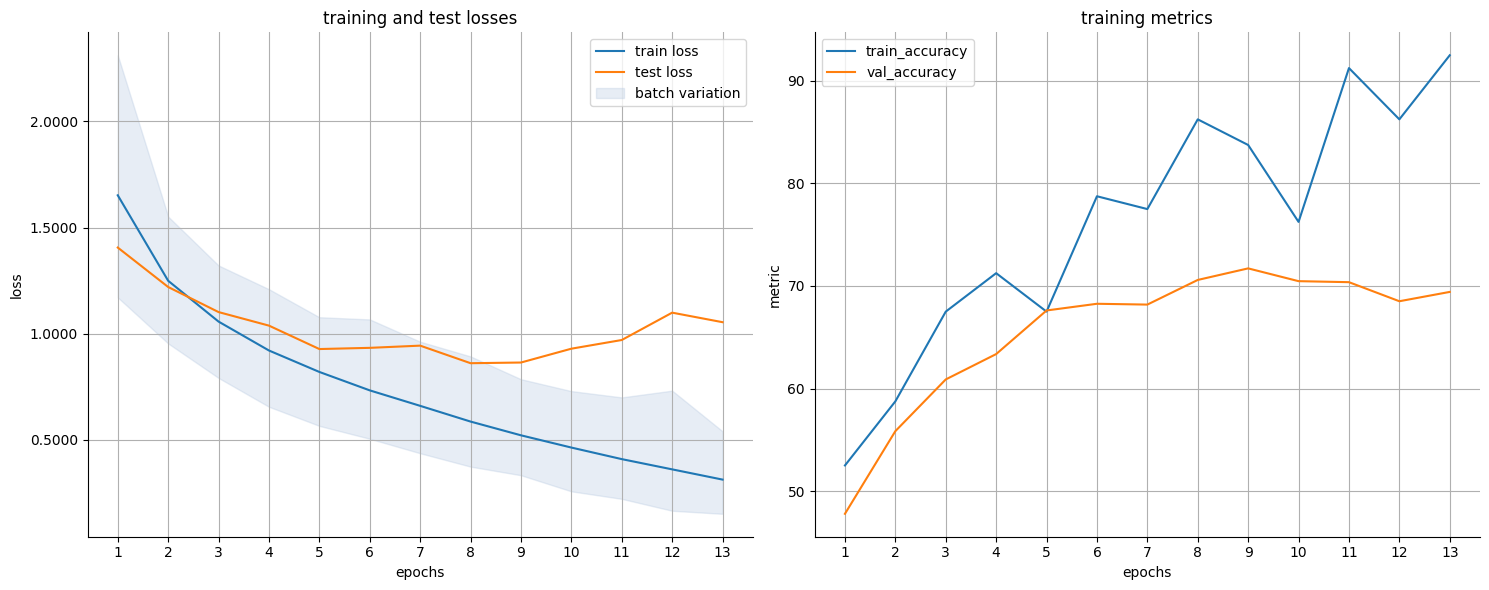

In [10]:
from models.resnet20.architecture import ResNet20

def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=3e-4)  # weight_decay=1e-4
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=None,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=False,
        # seed=42,
        # strict_reproducibility=True
        # wandb_project="cifar10",
        # wandb_entity="futuregoose",
        # sweep=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = ResNet20()
trainer1 = train_model(model1, "ResNet20", num_epochs=150)

[epoch 01] train loss: 1.6559 | val loss: 1.4462 | accuracy: 48.19%
Validation loss decreased (inf --> 1.4462). Saving model.
[epoch 02] train loss: 1.1063 | val loss: 1.4357 | accuracy: 53.00%
Validation loss decreased (1.4462 --> 1.4357). Saving model.
[epoch 03] train loss: 0.8221 | val loss: 0.8313 | accuracy: 70.61%
Validation loss decreased (1.4357 --> 0.8313). Saving model.
[epoch 04] train loss: 0.6683 | val loss: 0.7191 | accuracy: 75.94%
Validation loss decreased (0.8313 --> 0.7191). Saving model.
[epoch 05] train loss: 0.5673 | val loss: 0.6859 | accuracy: 76.61%
Validation loss decreased (0.7191 --> 0.6859). Saving model.
[epoch 06] train loss: 0.4993 | val loss: 0.6105 | accuracy: 79.60%
Validation loss decreased (0.6859 --> 0.6105). Saving model.
[epoch 07] train loss: 0.4389 | val loss: 0.5798 | accuracy: 80.81%
Validation loss decreased (0.6105 --> 0.5798). Saving model.
[epoch 08] train loss: 0.3913 | val loss: 0.5905 | accuracy: 79.91%
EarlyStopping counter: 1 out of 

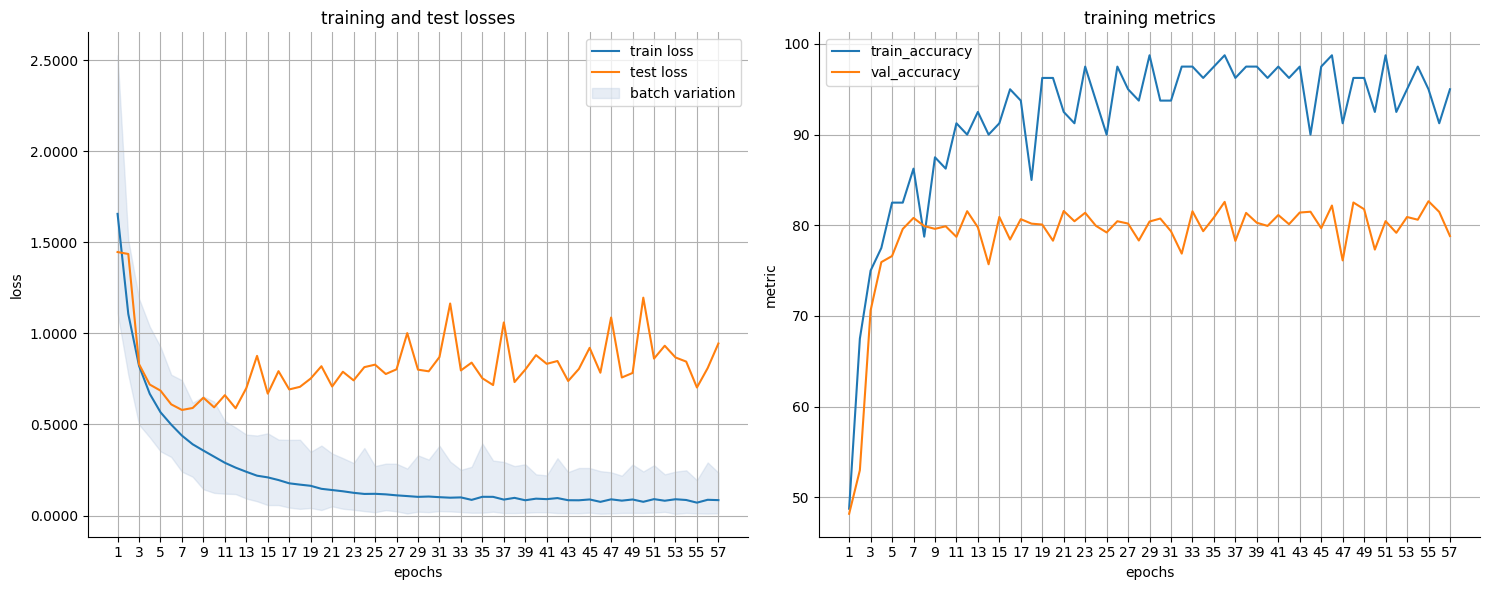

In [12]:
from models.resnet20.architecture import ResNet20

def train_model(model, model_name, num_epochs=25):
    optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=80, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=50,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=False,
        # seed=42,
        # strict_reproducibility=True
        # wandb_project="cifar10",
        # wandb_entity="futuregoose",
        # sweep=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model2 = ResNet20()
trainer2 = train_model(model2, "ResNet20", num_epochs=200)

In [14]:
from torch.optim.lr_scheduler import MultiStepLR
from models.resnet20.architecture import ResNet20

def train_model(model, model_name, num_epochs=200):
    """
    Train model following ResNet paper specifications
    - Initial LR: 0.1
    - SGD with momentum 0.9 and weight decay 1e-4
    - LR drops by 0.1 at epochs 82 and 123 (equivalent to 32k and 48k iterations)
    - Batch size 128
    - No early stopping (or very relaxed)
    """
    optimizer = SGD(
        model.parameters(),
        lr=0.1,                # paper's initial learning rate
        momentum=0.9,          # paper's momentum
        weight_decay=1e-4,     # paper's weight decay
        nesterov=True          # use nesterov momentum for better performance
    )
    
    # Learning rate drops at 32k and 48k iterations
    # With batch_size=128, one epoch = 391 iterations (50,000/128)
    # So 32k iterations ≈ 82 epochs, 48k iterations ≈ 123 epochs
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # epochs where we drop the learning rate
        gamma=0.1              # multiply lr by 0.1 at each milestone
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,        # paper's batch size
        verbose=True,
        save_metrics=True,
        # Either remove early stopping or make it very relaxed
        early_stopping_patience=150,  # very relaxed, almost entire training
        early_stopping_delta=1e-3,   # less stringent delta
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=False,
        # seed=42,  # uncomment if you want reproducibility
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # paper trains for ~164 epochs (64k iterations)
    )
    
    return trainer

# Train ResNet-20
model2 = ResNet20()
trainer2 = train_model(model2, "ResNet20", num_epochs=200)

[epoch 01] train loss: 1.6627 | val loss: 1.3318 | accuracy: 52.17%
Validation loss decreased (inf --> 1.3318). Saving model.
[epoch 02] train loss: 1.0438 | val loss: 1.3103 | accuracy: 57.59%
Validation loss decreased (1.3318 --> 1.3103). Saving model.
[epoch 03] train loss: 0.7771 | val loss: 0.8818 | accuracy: 70.13%
Validation loss decreased (1.3103 --> 0.8818). Saving model.
[epoch 04] train loss: 0.6223 | val loss: 0.8094 | accuracy: 73.36%
Validation loss decreased (0.8818 --> 0.8094). Saving model.
[epoch 05] train loss: 0.5325 | val loss: 0.7517 | accuracy: 74.86%
Validation loss decreased (0.8094 --> 0.7517). Saving model.
[epoch 06] train loss: 0.4659 | val loss: 0.6794 | accuracy: 77.43%
Validation loss decreased (0.7517 --> 0.6794). Saving model.
[epoch 07] train loss: 0.4089 | val loss: 0.5648 | accuracy: 81.36%
Validation loss decreased (0.6794 --> 0.5648). Saving model.
[epoch 08] train loss: 0.3626 | val loss: 0.6197 | accuracy: 79.73%
EarlyStopping counter: 1 out of 

[epoch 01] train loss: 1.6478 | val loss: 1.4581 | accuracy: 45.54%
Validation loss decreased (inf --> 1.4581). Saving model.
[epoch 02] train loss: 1.0651 | val loss: 1.5618 | accuracy: 51.85%
EarlyStopping counter: 1 out of inf
[epoch 03] train loss: 0.8062 | val loss: 0.8814 | accuracy: 70.30%
Validation loss decreased (1.4581 --> 0.8814). Saving model.
[epoch 04] train loss: 0.6651 | val loss: 0.8475 | accuracy: 71.31%
Validation loss decreased (0.8814 --> 0.8475). Saving model.
[epoch 05] train loss: 0.5663 | val loss: 0.7210 | accuracy: 75.45%
Validation loss decreased (0.8475 --> 0.7210). Saving model.
[epoch 06] train loss: 0.4973 | val loss: 0.6760 | accuracy: 78.07%
Validation loss decreased (0.7210 --> 0.6760). Saving model.
[epoch 07] train loss: 0.4432 | val loss: 0.6824 | accuracy: 77.44%
EarlyStopping counter: 1 out of inf
[epoch 08] train loss: 0.3968 | val loss: 0.6503 | accuracy: 78.62%
Validation loss decreased (0.6760 --> 0.6503). Saving model.
[epoch 09] train loss

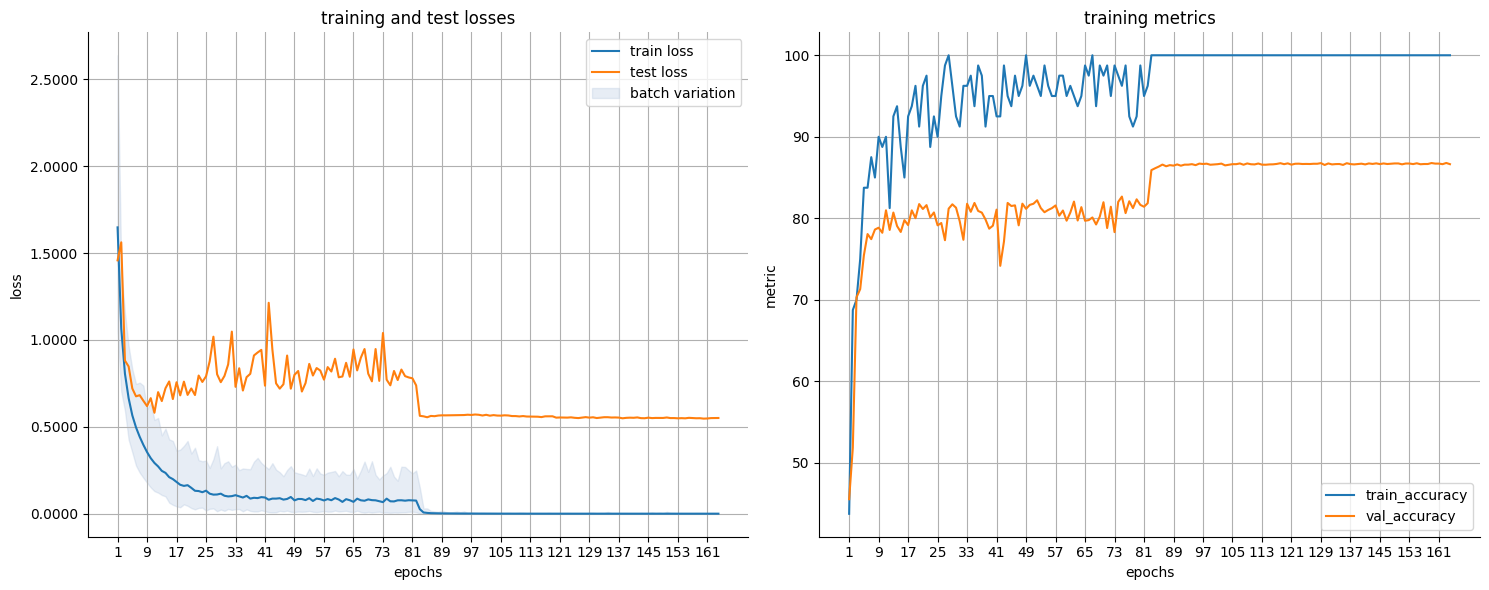

In [5]:
from torch.optim.lr_scheduler import MultiStepLR
from models.resnet20.architecture import ResNet20

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4,
        nesterov=False  # Paper doesn't mention Nesterov
    )
    
    # 32k and 48k iterations with batch_size=128
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # ~32k and ~48k iterations
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        # Remove early stopping to match paper
        early_stopping_patience=float('inf'),  # effectively no early stopping
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # 164 to reach ~64k iterations
    )
    
    return trainer

# Train ResNet-20
model2 = ResNet20()
trainer2 = train_model(model2, "ResNet20", num_epochs=164)

In [ ]:
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import MultiStepLR

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.06697728766802258,  # 0.1
        momentum=0.9,
        weight_decay=7.677453602367855e-05,  # 1e-4
        nesterov=False  # Paper doesn't mention Nesterov
    )
    
    # 32k and 48k iterations with batch_size=128
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # ~32k and ~48k iterations
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=64,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=10,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="wandb",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # 164 to reach ~64k iterations
    )
    
    return trainer

model3 = EightLayerConvNet()
trainer3 = train_model(model3, "EightLayerConvNet", num_epochs=100)

In [6]:
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import MultiStepLR

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4,
        nesterov=False  # Paper doesn't mention Nesterov
    )
    
    # 32k and 48k iterations with batch_size=128
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # ~32k and ~48k iterations
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=8,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="wandb",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=True,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # 164 to reach ~64k iterations
    )
    
    return trainer

# Train ResNet-20
model3 = EightLayerConvNet()
trainer3 = train_model(model3, "EightLayerConvNet", num_epochs=60)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: evilgoosecode (futuregoose). Use `wandb login --relogin` to force relogin


Create sweep with ID: 84s00ita
Sweep URL: https://wandb.ai/futuregoose/cifar10/sweeps/84s00ita
sweep url: https://wandb.ai/futuregoose/cifar10/sweeps/84s00ita

Starting sweep...
Running 100 trials...


wandb: Agent Starting Run: e5qw2c0o with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08305285506947262
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 50
wandb: 	weight_decay: 7.053318263930236e-05



run fragrant-sweep-1 - batch_size: 256, lr: 0.08305, optimizer: SGD
[epoch 01] train loss: 1.4675 | val loss: 1.6173 | accuracy: 41.82%
Validation loss decreased (inf --> 1.6173). Saving model.
[epoch 02] train loss: 1.1244 | val loss: 2.6412 | accuracy: 34.64%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 0.9758 | val loss: 1.6969 | accuracy: 44.98%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 0.8777 | val loss: 1.0282 | accuracy: 64.40%
Validation loss decreased (1.6173 --> 1.0282). Saving model.
[epoch 05] train loss: 0.8020 | val loss: 1.2232 | accuracy: 57.75%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 0.7432 | val loss: 1.3924 | accuracy: 54.91%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 0.6985 | val loss: 2.6282 | accuracy: 37.06%
EarlyStopping counter: 3 out of 5
[epoch 08] train loss: 0.6573 | val loss: 0.7726 | accuracy: 73.41%
Validation loss decreased (1.0282 --> 0.7726). Saving model.
[epoch 09] train loss: 0.6274 | val l

batch_loss,█▅▅▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▂▂▁▂
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_accuracy,▄▁▄▄▄▅▄▆▆▅▇▄▇▆█▇███▇█▆▇▇█
train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▃▆▅▄▁▇▆▇▇█▇████████████
val_loss,▄█▅▂▃▄█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.51017
epoch,25
train_accuracy,85
train_loss,0.51211
val_accuracy,78.95508


wandb: Agent Starting Run: sd7r07qe with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.012805233433849305
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 48
wandb: 	weight_decay: 6.482487936828936e-05



run frosty-sweep-2 - batch_size: 128, lr: 0.01281, optimizer: SGD
[epoch 01] train loss: 0.6542 | val loss: 1.3434 | accuracy: 56.62%
Validation loss decreased (inf --> 1.3434). Saving model.
[epoch 02] train loss: 0.5800 | val loss: 0.8459 | accuracy: 70.92%
Validation loss decreased (1.3434 --> 0.8459). Saving model.
[epoch 03] train loss: 0.5285 | val loss: 0.8519 | accuracy: 69.69%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 0.4866 | val loss: 0.7136 | accuracy: 75.58%
Validation loss decreased (0.8459 --> 0.7136). Saving model.
[epoch 05] train loss: 0.4539 | val loss: 0.7338 | accuracy: 74.61%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 0.4267 | val loss: 0.7014 | accuracy: 76.37%
Validation loss decreased (0.7136 --> 0.7014). Saving model.
[epoch 07] train loss: 0.4049 | val loss: 0.5917 | accuracy: 80.38%
Validation loss decreased (0.7014 --> 0.5917). Saving model.
[epoch 08] train loss: 0.3871 | val loss: 0.6282 | accuracy: 79.02%
EarlyStopping count

batch_loss,▇█▇▆▆▅▆▅▅▄▃▅▃▃▃▄▃▂▃▂▂▃▃▃▂▁▄▁▂▁▁▁▃▂▁▁▂▂▂▂
epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇██████
train_accuracy,▁▆▁▅▄▄▇▆▇▅█▆▇▆▆▆█
train_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆█▇█████████
val_loss,█▄▄▂▃▂▁▂▁▁▁▁▁▁▁▁▁
batch_loss,0.3198
epoch,17
train_accuracy,96.25
train_loss,0.33064
val_accuracy,81.85324


wandb: Agent Starting Run: 56vi006y with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.06697728766802258
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 22
wandb: 	weight_decay: 7.677453602367855e-05



run earnest-sweep-3 - batch_size: 64, lr: 0.06698, optimizer: SGD
[epoch 01] train loss: 0.9573 | val loss: 1.5032 | accuracy: 53.55%
Validation loss decreased (inf --> 1.5032). Saving model.
[epoch 02] train loss: 0.6916 | val loss: 2.6426 | accuracy: 32.16%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 0.5864 | val loss: 2.3117 | accuracy: 38.44%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 0.5050 | val loss: 0.8244 | accuracy: 72.31%
Validation loss decreased (1.5032 --> 0.8244). Saving model.
[epoch 05] train loss: 0.4319 | val loss: 0.7002 | accuracy: 76.94%
Validation loss decreased (0.8244 --> 0.7002). Saving model.
[epoch 06] train loss: 0.3707 | val loss: 0.5265 | accuracy: 82.52%
Validation loss decreased (0.7002 --> 0.5265). Saving model.
[epoch 07] train loss: 0.3148 | val loss: 0.6362 | accuracy: 79.90%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 0.2626 | val loss: 0.9194 | accuracy: 71.30%
EarlyStopping counter: 2 out of 5
[epoch 09] t

batch_loss,▇█▆▆▅▅▄▄▃▃▂▃▃▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████
train_accuracy,▃▁▂▇▃▇▂▆▇▆▇█▇█▇█████▇█
train_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▁▂▆▇▇▇▆▇█████████████
val_loss,▄█▇▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.13822
epoch,22
train_accuracy,100
train_loss,0.08039
val_accuracy,87.78861


wandb: Agent Starting Run: k2g0ip96 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.05457571181702842
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 24
wandb: 	weight_decay: 7.751100225344592e-05



run comfy-sweep-4 - batch_size: 128, lr: 0.05458, optimizer: Adam
[epoch 01] train loss: 2.0869 | val loss: 11.3251 | accuracy: 9.89%
Validation loss decreased (inf --> 11.3251). Saving model.
[epoch 02] train loss: 2.0027 | val loss: 2.1581 | accuracy: 17.15%
Validation loss decreased (11.3251 --> 2.1581). Saving model.
[epoch 03] train loss: 1.9698 | val loss: 1.9866 | accuracy: 19.35%
Validation loss decreased (2.1581 --> 1.9866). Saving model.
[epoch 04] train loss: 1.9512 | val loss: 1.9650 | accuracy: 20.33%
Validation loss decreased (1.9866 --> 1.9650). Saving model.
[epoch 05] train loss: 1.8403 | val loss: 1.9935 | accuracy: 21.34%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.7804 | val loss: 1.8597 | accuracy: 26.07%
Validation loss decreased (1.9650 --> 1.8597). Saving model.
[epoch 07] train loss: 1.7474 | val loss: 1.8097 | accuracy: 27.67%
Validation loss decreased (1.8597 --> 1.8097). Saving model.
[epoch 08] train loss: 1.7270 | val loss: 2.0168 | accurac

batch_loss,█▆▆▆▅▆▃▄▄▄▃▃▄▄▃▂▃▃▃▂▂▂▂▂▂▂▁▂▂▃▃▂▁▂▂▃▂▂▁▃
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▁▁▃▂▅▄▇▇▅▇▇▅▇▅▆▆▆▇▇▇█▇▆█▅▆▆▆▅
train_loss,█▇▆▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▄▆▇▇▇▇▇▇██████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.657
epoch,29
train_accuracy,31.25
train_loss,1.58353
val_accuracy,37.79668


wandb: Agent Starting Run: do45cbn6 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.05914180617308265
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 32
wandb: 	weight_decay: 1.767013009517391e-05



run glad-sweep-5 - batch_size: 64, lr: 0.05914, optimizer: SGD
[epoch 01] train loss: 1.7393 | val loss: 1.7296 | accuracy: 31.19%
Validation loss decreased (inf --> 1.7296). Saving model.
[epoch 02] train loss: 1.6640 | val loss: 1.9470 | accuracy: 27.17%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.6416 | val loss: 1.9422 | accuracy: 26.65%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 1.6233 | val loss: 2.2533 | accuracy: 21.45%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 1.6104 | val loss: 1.6309 | accuracy: 35.60%
Validation loss decreased (1.7296 --> 1.6309). Saving model.
[epoch 06] train loss: 1.5954 | val loss: 1.6247 | accuracy: 36.07%
Validation loss decreased (1.6309 --> 1.6247). Saving model.
[epoch 07] train loss: 1.5836 | val loss: 1.7305 | accuracy: 32.94%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.5763 | val loss: 1.6559 | accuracy: 35.34%
EarlyStopping counter: 2 out of 5
[epoch 09] train loss: 1.5684 | val loss: 

batch_loss,█▆▄▃▅█▅▆▄▂▁▂▃▃▅▂▅▂▃▁▃▆▂▃▃▄▃▂▇▃▁▃▄█▂▄▃▅▄▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train_accuracy,▃▇▄▅▅▆▆▄▅▃▃▅▇▄▄▅▂▅▇▇▇▃█▄▁
train_loss,█▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▃▃▁▆▆▅▆▇▅▇▇▇███▇▇▇█▇█▆██
val_loss,▃▅▅█▂▂▃▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁
batch_loss,2.12866
epoch,25
train_accuracy,18.75
train_loss,1.54441
val_accuracy,38.99283


wandb: Agent Starting Run: soeg33ik with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.08329119033881542
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 32
wandb: 	weight_decay: 5.7452460209806554e-05



run restful-sweep-6 - batch_size: 64, lr: 0.08329, optimizer: SGD
[epoch 01] train loss: 1.8649 | val loss: 2.8086 | accuracy: 18.58%
Validation loss decreased (inf --> 2.8086). Saving model.
[epoch 02] train loss: 1.7672 | val loss: 1.8454 | accuracy: 27.59%
Validation loss decreased (2.8086 --> 1.8454). Saving model.
[epoch 03] train loss: 1.7328 | val loss: 2.6904 | accuracy: 17.45%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.7148 | val loss: 1.8933 | accuracy: 26.25%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 1.6993 | val loss: 1.7943 | accuracy: 29.93%
Validation loss decreased (1.8454 --> 1.7943). Saving model.
[epoch 06] train loss: 1.6876 | val loss: 2.0209 | accuracy: 24.23%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.6758 | val loss: 3.0665 | accuracy: 12.57%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.6653 | val loss: 1.8451 | accuracy: 26.44%
EarlyStopping counter: 3 out of 5
[epoch 09] train loss: 1.6572 | val los

batch_loss,▇█▇▆▆▄▄▅▅▃▃▁▂▇▂▂▃▂▃▄▅▂▃▄▅▄▄▃▅▄▂▂▄▁▅▃▂▁▂▂
epoch,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▂▃▃▁█▃▂▃▃▂▃▂▃▅█▅▂▃▃▃▃▂▂
train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▅▂▅▆▄▁▅█▇▇█▇██████▇███
val_loss,▇▂▆▂▂▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.40622
epoch,23
train_accuracy,25
train_loss,1.6242
val_accuracy,36.22611


wandb: Agent Starting Run: 6tyxl9zu with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.09794663501786811
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 48
wandb: 	weight_decay: 9.152453245870576e-05



run brisk-sweep-7 - batch_size: 256, lr: 0.09795, optimizer: SGD
[epoch 01] train loss: 1.9743 | val loss: 1.8771 | accuracy: 26.46%
Validation loss decreased (inf --> 1.8771). Saving model.
[epoch 02] train loss: 1.7906 | val loss: 1.8271 | accuracy: 27.88%
Validation loss decreased (1.8771 --> 1.8271). Saving model.
[epoch 03] train loss: 1.7457 | val loss: 1.7917 | accuracy: 27.02%
Validation loss decreased (1.8271 --> 1.7917). Saving model.
[epoch 04] train loss: 1.7280 | val loss: 1.7398 | accuracy: 31.96%
Validation loss decreased (1.7917 --> 1.7398). Saving model.
[epoch 05] train loss: 1.7143 | val loss: 1.7855 | accuracy: 29.84%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.7047 | val loss: 1.7242 | accuracy: 30.70%
Validation loss decreased (1.7398 --> 1.7242). Saving model.
[epoch 07] train loss: 1.6990 | val loss: 1.7109 | accuracy: 33.63%
Validation loss decreased (1.7242 --> 1.7109). Saving model.
[epoch 08] train loss: 1.6926 | val loss: 1.7124 | accuracy: 

batch_loss,█▄▆▆▅▆▅▄▄▂▄▃▄▅▅▃▆▅▃▄▁▂▂▃▂▅▃▄▆▄▂▁▄▂▂▃▄▄▂▃
epoch,▁▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
train_accuracy,▂▂▂▁▁▅▆▆▇▂▃▄▆▃▇▂▂█▆▄▄█
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▆▄▅▇▆▇▄▇▇▇██▇█▇████
val_loss,█▆▅▃▅▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.63328
epoch,22
train_accuracy,45
train_loss,1.67537
val_accuracy,34.00391


wandb: Agent Starting Run: gnn2ktb2 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0313877981444201
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 43
wandb: 	weight_decay: 4.650808786824096e-05



run peach-sweep-8 - batch_size: 128, lr: 0.03139, optimizer: SGD
[epoch 01] train loss: 1.7234 | val loss: 1.7761 | accuracy: 30.78%
Validation loss decreased (inf --> 1.7761). Saving model.
[epoch 02] train loss: 1.6971 | val loss: 1.9541 | accuracy: 23.86%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.6901 | val loss: 1.7177 | accuracy: 31.31%
Validation loss decreased (1.7761 --> 1.7177). Saving model.
[epoch 04] train loss: 1.6810 | val loss: 1.6804 | accuracy: 33.52%
Validation loss decreased (1.7177 --> 1.6804). Saving model.
[epoch 05] train loss: 1.6727 | val loss: 1.6675 | accuracy: 34.02%
Validation loss decreased (1.6804 --> 1.6675). Saving model.
[epoch 06] train loss: 1.6697 | val loss: 1.6652 | accuracy: 34.62%
Validation loss decreased (1.6675 --> 1.6652). Saving model.
[epoch 07] train loss: 1.6657 | val loss: 1.6812 | accuracy: 34.01%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.6628 | val loss: 1.6748 | accuracy: 34.00%
EarlyStopping counte

batch_loss,█▄▅▄▃▇▅▃▄▂▅▄▂▄▄▂▃▄▂▃▄▃▄▁▂▃▂▃▄▂▁▄▁▃▃▄▂▃▃▂
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
train_accuracy,▁▂▄▄▅▅▄▃▅▅▇▆▅▅▇█▅▅▆▃▅▁▂▅
train_loss,█▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▁▆▇▇█▇▇▇███▇██████▇██▇█
val_loss,▄█▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.63172
epoch,24
train_accuracy,35
train_loss,1.65388
val_accuracy,34.47389


wandb: Agent Starting Run: g5t54ewf with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.040229374805186846
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 42
wandb: 	weight_decay: 7.639710821548577e-05



run comfy-sweep-9 - batch_size: 256, lr: 0.04023, optimizer: SGD
[epoch 01] train loss: 1.7377 | val loss: 1.8654 | accuracy: 27.11%
Validation loss decreased (inf --> 1.8654). Saving model.
[epoch 02] train loss: 1.6803 | val loss: 2.4668 | accuracy: 19.10%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.6708 | val loss: 1.7248 | accuracy: 31.77%
Validation loss decreased (1.8654 --> 1.7248). Saving model.
[epoch 04] train loss: 1.6622 | val loss: 1.8031 | accuracy: 26.37%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.6569 | val loss: 1.7145 | accuracy: 31.68%
Validation loss decreased (1.7248 --> 1.7145). Saving model.
[epoch 06] train loss: 1.6537 | val loss: 1.6810 | accuracy: 32.78%
Validation loss decreased (1.7145 --> 1.6810). Saving model.
[epoch 07] train loss: 1.6512 | val loss: 1.6955 | accuracy: 32.41%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.6485 | val loss: 1.6649 | accuracy: 32.79%
Validation loss decreased (1.6810 --> 1.6649). 

batch_loss,█▆▇▅▅▅▆▂▄▂▄▆▄▃▂▃▂▂▂▅▃▃▂▄▃▃▂▅▃▅▁▂▆▁▃▁▂▅▄▅
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_accuracy,▃▅▇▁▅▁▄▂▇▄▅▄▅▅▄▅█▃▇▄
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▁▆▄▆▇▇▇▇███████████
val_loss,▃█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.56176
epoch,20
train_accuracy,35
train_loss,1.64176
val_accuracy,35.14648


wandb: Agent Starting Run: 7jzi9615 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.07689823073630396
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 28
wandb: 	weight_decay: 6.664384472486169e-05



run robust-sweep-10 - batch_size: 64, lr: 0.07690, optimizer: Adam
[epoch 01] train loss: 2.0340 | val loss: 2.2667 | accuracy: 12.46%
Validation loss decreased (inf --> 2.2667). Saving model.
[epoch 02] train loss: 2.0416 | val loss: 2.0529 | accuracy: 15.86%
Validation loss decreased (2.2667 --> 2.0529). Saving model.
[epoch 03] train loss: 2.0268 | val loss: 2.1910 | accuracy: 13.03%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.0186 | val loss: 1.9975 | accuracy: 20.58%
Validation loss decreased (2.0529 --> 1.9975). Saving model.
[epoch 05] train loss: 2.0060 | val loss: 2.2310 | accuracy: 12.38%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.0008 | val loss: 1.9650 | accuracy: 19.00%
Validation loss decreased (1.9975 --> 1.9650). Saving model.
[epoch 07] train loss: 1.9906 | val loss: 2.0175 | accuracy: 18.02%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.9747 | val loss: 1.9893 | accuracy: 19.85%
EarlyStopping counter: 2 out of 5
[epoch 09] 

batch_loss,▇▇▇█▆▇█▇█▆▅▄▄▆▅▅▅▄▄▃▂▂▃▂▁▂▁▃▃▂▃▃▂▂▂▂▃▃▃▂
epoch,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▃▃▂▃▃▂▃▁▄▄▅▅▃▆▂▅▄▆▆▅▅█▃▆▆▆▃▅▆▇▆▅▄▅
train_loss,██████▇▇▆▆▅▅▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▃▁▂▂▂▃▄▄▄▅▅▅▆▆▆▇▇▇█▇█████████████
val_loss,█▆▇▆█▆▆▆▅▅▅▄▃▃▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.44675
epoch,36
train_accuracy,43.75
train_loss,1.3739
val_accuracy,47.83041


wandb: Agent Starting Run: whqobf4q with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.06513591298446758
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 31
wandb: 	weight_decay: 2.5409494414200858e-05



run dashing-sweep-11 - batch_size: 64, lr: 0.06514, optimizer: Adam
[epoch 01] train loss: 1.9910 | val loss: 2.1736 | accuracy: 22.51%
Validation loss decreased (inf --> 2.1736). Saving model.
[epoch 02] train loss: 1.9254 | val loss: 2.0809 | accuracy: 20.04%
Validation loss decreased (2.1736 --> 2.0809). Saving model.
[epoch 03] train loss: 1.8820 | val loss: 3.2526 | accuracy: 11.20%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.8497 | val loss: 2.0072 | accuracy: 21.83%
Validation loss decreased (2.0809 --> 2.0072). Saving model.
[epoch 05] train loss: 1.8285 | val loss: 1.9908 | accuracy: 23.36%
Validation loss decreased (2.0072 --> 1.9908). Saving model.
[epoch 06] train loss: 1.8134 | val loss: 1.9707 | accuracy: 21.96%
Validation loss decreased (1.9908 --> 1.9707). Saving model.
[epoch 07] train loss: 1.7974 | val loss: 1.7669 | accuracy: 28.88%
Validation loss decreased (1.9707 --> 1.7669). Saving model.
[epoch 08] train loss: 1.7881 | val loss: 1.8428 | accurac

batch_loss,▅█▆▅▆▇█▄▃▄▃▄▃▆▂▂▃▄▄▄▃▂▄▃▅▆▄▂▅▃▂▄▄▄▄▂▄▂▁▅
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
train_accuracy,▂▂▂▂▅▁▅▃▂▅█▃▂▅▂▂▃▄▄▄▂▄▃▂▄▅▅▅▅
train_loss,█▇▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▄▁▄▅▄▆▆▅▆▇▆▇▇▇▇█████████████
val_loss,▃▃█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.56497
epoch,29
train_accuracy,37.5
train_loss,1.64663
val_accuracy,34.02667


wandb: Agent Starting Run: sdmqwj9a with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.09636485890478248
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 22
wandb: 	weight_decay: 9.606315159882856e-05



run iconic-sweep-12 - batch_size: 64, lr: 0.09636, optimizer: SGD
[epoch 01] train loss: 1.8880 | val loss: 2.1416 | accuracy: 21.86%
Validation loss decreased (inf --> 2.1416). Saving model.
[epoch 02] train loss: 1.7582 | val loss: 1.7333 | accuracy: 31.93%
Validation loss decreased (2.1416 --> 1.7333). Saving model.
[epoch 03] train loss: 1.7162 | val loss: 1.7496 | accuracy: 29.39%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.6958 | val loss: 2.8087 | accuracy: 14.07%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 1.6818 | val loss: 1.9500 | accuracy: 24.27%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 1.6700 | val loss: 1.7327 | accuracy: 32.43%
Validation loss decreased (1.7333 --> 1.7327). Saving model.
[epoch 07] train loss: 1.6588 | val loss: 1.6676 | accuracy: 34.10%
Validation loss decreased (1.7327 --> 1.6676). Saving model.
[epoch 08] train loss: 1.6475 | val loss: 1.6477 | accuracy: 33.61%
Validation loss decreased (1.6676 --> 1.6477).

batch_loss,█▅▅▄▇▃▅▅▆▄▃▃▃▅▆▅▄▅▃▃▄▃▁▂▅▁▁▄▅▃▅▃▁▃▃▂▃▂▄█
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇█████
train_accuracy,▃▂▇▂▃▇▅▁▃▄▇▆██▇▅▄▆█▅█▅
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▆▆▁▄▇▇▇▆▆▇▇▇█████████
val_loss,▄▂▂█▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.62127
epoch,22
train_accuracy,37.5
train_loss,1.60481
val_accuracy,37.21139


wandb: Agent Starting Run: v3i6omzm with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.00027118086071544894
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 38
wandb: 	weight_decay: 9.462093665175282e-05



run denim-sweep-13 - batch_size: 256, lr: 0.00027, optimizer: SGD
[epoch 01] train loss: 1.5918 | val loss: 1.6110 | accuracy: 36.62%
Validation loss decreased (inf --> 1.6110). Saving model.
[epoch 02] train loss: 1.5910 | val loss: 1.6062 | accuracy: 36.83%
Validation loss decreased (1.6110 --> 1.6062). Saving model.
[epoch 03] train loss: 1.5916 | val loss: 1.6073 | accuracy: 36.68%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.5915 | val loss: 1.6119 | accuracy: 36.82%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 1.5912 | val loss: 1.6076 | accuracy: 37.11%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 1.5913 | val loss: 1.6111 | accuracy: 36.75%
EarlyStopping counter: 4 out of 5
[epoch 07] train loss: 1.5921 | val loss: 1.6094 | accuracy: 36.84%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▄▁▂▄▄▅▅▄▄▇▃▂▃▆▂▄▃▄▄▂▄▃▂▄▅▆▄▄▄▅▁▅▃▄▇▂▄█▆▅
epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
train_accuracy,▁█▇▄▇▆▆
train_loss,▆▁▅▄▂▃█
val_accuracy,▁▄▂▄█▃▄
val_loss,▇▁▂█▃▇▅
batch_loss,1.64049
epoch,7
train_accuracy,40
train_loss,1.59208
val_accuracy,36.83594


wandb: Agent Starting Run: cfpoewr4 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.04371244880164003
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 49
wandb: 	weight_decay: 4.9409067136729153e-05



run charmed-sweep-14 - batch_size: 64, lr: 0.04371, optimizer: SGD
[epoch 01] train loss: 1.7338 | val loss: 1.9934 | accuracy: 25.93%
Validation loss decreased (inf --> 1.9934). Saving model.
[epoch 02] train loss: 1.6702 | val loss: 1.9897 | accuracy: 22.41%
Validation loss decreased (1.9934 --> 1.9897). Saving model.
[epoch 03] train loss: 1.6524 | val loss: 1.7405 | accuracy: 31.44%
Validation loss decreased (1.9897 --> 1.7405). Saving model.
[epoch 04] train loss: 1.6370 | val loss: 1.6613 | accuracy: 35.52%
Validation loss decreased (1.7405 --> 1.6613). Saving model.
[epoch 05] train loss: 1.6272 | val loss: 1.8749 | accuracy: 28.25%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.6171 | val loss: 1.6398 | accuracy: 35.48%
Validation loss decreased (1.6613 --> 1.6398). Saving model.
[epoch 07] train loss: 1.6076 | val loss: 1.8089 | accuracy: 30.69%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.6027 | val loss: 1.6329 | accuracy: 36.04%
Validation loss de

batch_loss,█▅▄▅▃▄▂▅▃▄▅▃▃▅▃▃▃▃▄▃▄▄▂▃▁▃▁▂▄▁▃▃▂▃▁▄▂▄▄▃
epoch,▁▁▁▁▁▂▂▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▅▂▇▅▅▄▃▆▆▇█▆▆▃█▅▁▆▄▅▅▅
train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▁▅▇▄▇▅▇██████▇▇█████▇
val_loss,██▄▂▆▂▅▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
batch_loss,1.65042
epoch,22
train_accuracy,37.5
train_loss,1.58026
val_accuracy,37.38057


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z55j4527 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.03292135543240767
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 22
wandb: 	weight_decay: 6.857691878874802e-05



run winter-sweep-15 - batch_size: 64, lr: 0.03292, optimizer: SGD
[epoch 01] train loss: 1.6842 | val loss: 2.1336 | accuracy: 25.78%
Validation loss decreased (inf --> 2.1336). Saving model.
[epoch 02] train loss: 1.6363 | val loss: 1.8643 | accuracy: 30.21%
Validation loss decreased (2.1336 --> 1.8643). Saving model.
[epoch 03] train loss: 1.6194 | val loss: 2.1452 | accuracy: 23.58%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.6097 | val loss: 1.8513 | accuracy: 30.21%
Validation loss decreased (1.8643 --> 1.8513). Saving model.
[epoch 05] train loss: 1.6018 | val loss: 1.6334 | accuracy: 36.65%
Validation loss decreased (1.8513 --> 1.6334). Saving model.
[epoch 06] train loss: 1.5928 | val loss: 1.8408 | accuracy: 30.66%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.5883 | val loss: 1.5872 | accuracy: 38.45%
Validation loss decreased (1.6334 --> 1.5872). Saving model.
[epoch 08] train loss: 1.5830 | val loss: 1.6051 | accuracy: 39.63%
EarlyStopping count

batch_loss,▆█▆▁▄▅▇▂▆▂▁▄▃▃▅▅▂▅▃▅▄▇▄▁▄▅▃▂▂▇▄▃▂▁▅▃▃▂▃▃
epoch,▁▁▁▁▁▁▂▂▂▂▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▆▁▆▃▃▃▁▁██▆█
train_loss,█▅▄▃▃▂▂▂▁▁▁▁
val_accuracy,▂▄▁▄▇▄▇█▇▇██
val_loss,█▄█▄▂▄▁▁▁▂▁▁
batch_loss,1.54607
epoch,12
train_accuracy,37.5
train_loss,1.57213
val_accuracy,38.89331


wandb: Agent Starting Run: 8v68xm9m with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.04152718098691663
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 41
wandb: 	weight_decay: 4.427862561962486e-05



run ethereal-sweep-16 - batch_size: 256, lr: 0.04153, optimizer: SGD
[epoch 01] train loss: 1.6668 | val loss: 1.8395 | accuracy: 30.14%
Validation loss decreased (inf --> 1.8395). Saving model.
[epoch 02] train loss: 1.5980 | val loss: 1.6508 | accuracy: 37.78%
Validation loss decreased (1.8395 --> 1.6508). Saving model.
[epoch 03] train loss: 1.5837 | val loss: 1.7089 | accuracy: 35.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.5743 | val loss: 1.6143 | accuracy: 37.16%
Validation loss decreased (1.6508 --> 1.6143). Saving model.
[epoch 05] train loss: 1.5676 | val loss: 1.6216 | accuracy: 37.50%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.5628 | val loss: 1.6060 | accuracy: 38.41%
Validation loss decreased (1.6143 --> 1.6060). Saving model.
[epoch 07] train loss: 1.5602 | val loss: 1.5774 | accuracy: 40.22%
Validation loss decreased (1.6060 --> 1.5774). Saving model.
[epoch 08] train loss: 1.5568 | val loss: 1.5812 | accuracy: 39.85%
EarlyStopping co

batch_loss,▄▅▆▇▆█▃▄▅█▆▂▆▃▄▅▅▄▂▅▂▁▄▃▃▄▅▂▅█▃▄▂▅▅▂▂▇▅▆
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_accuracy,▁▃▅▅▅▇▇▅▃▇▃▇▄▃█▅█▅▅▅
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▅▆▆▇██▇███████████
val_loss,█▃▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.55966
epoch,20
train_accuracy,41.25
train_loss,1.55066
val_accuracy,40.26367


wandb: Agent Starting Run: v8otgh1h with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.02281866287328787
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 7.422158750944346e-05



run trim-sweep-17 - batch_size: 64, lr: 0.02282, optimizer: SGD
[epoch 01] train loss: 1.6366 | val loss: 1.7294 | accuracy: 32.86%
Validation loss decreased (inf --> 1.7294). Saving model.
[epoch 02] train loss: 1.6086 | val loss: 2.0885 | accuracy: 23.53%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.5998 | val loss: 2.0262 | accuracy: 21.89%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 1.5880 | val loss: 1.6938 | accuracy: 34.21%
Validation loss decreased (1.7294 --> 1.6938). Saving model.
[epoch 05] train loss: 1.5823 | val loss: 1.5970 | accuracy: 38.61%
Validation loss decreased (1.6938 --> 1.5970). Saving model.
[epoch 06] train loss: 1.5778 | val loss: 1.6103 | accuracy: 37.64%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.5718 | val loss: 1.5914 | accuracy: 38.70%
Validation loss decreased (1.5970 --> 1.5914). Saving model.
[epoch 08] train loss: 1.5687 | val loss: 1.5761 | accuracy: 39.85%
Validation loss decreased (1.5914 --> 1.5761). S

batch_loss,▅▅▄▅▂▃▄▂█▁▄▂▂▅▄▁▃▃▄▂▅▃▁▄▃▅▄▃▃▃▄▂▂▇▄█▂▂▃▃
epoch,▁▁▁▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████████
train_accuracy,▄▅▆▅█▁▆▆▄▂▂▅▄▄▄▅▅
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▅▂▁▆▇▇▇█████▇████
val_loss,▃█▇▃▁▂▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.43574
epoch,17
train_accuracy,43.75
train_loss,1.55649
val_accuracy,40.43591


wandb: Agent Starting Run: 5qpmky24 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.056455634799467955
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 20
wandb: 	weight_decay: 1.665858434051255e-05



run logical-sweep-18 - batch_size: 128, lr: 0.05646, optimizer: SGD
[epoch 01] train loss: 1.7937 | val loss: 1.7305 | accuracy: 33.19%
Validation loss decreased (inf --> 1.7305). Saving model.
[epoch 02] train loss: 1.6775 | val loss: 1.6695 | accuracy: 35.73%
Validation loss decreased (1.7305 --> 1.6695). Saving model.
[epoch 03] train loss: 1.6461 | val loss: 1.6572 | accuracy: 36.24%
Validation loss decreased (1.6695 --> 1.6572). Saving model.
[epoch 04] train loss: 1.6274 | val loss: 1.6828 | accuracy: 33.25%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.6157 | val loss: 1.8981 | accuracy: 27.57%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 1.6068 | val loss: 1.6118 | accuracy: 37.44%
Validation loss decreased (1.6572 --> 1.6118). Saving model.
[epoch 07] train loss: 1.6003 | val loss: 1.6299 | accuracy: 37.34%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.5953 | val loss: 1.6248 | accuracy: 38.36%
EarlyStopping counter: 2 out of 5
[epoch 09]

batch_loss,▆▄▄▅▅▇█▆▅▅▄▇▆▇▄▅█▄▄▇▃▅▄▅▄▂▃▄▅▁█▄▇▆▇▄▅█▄▃
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_accuracy,▅▂▂▅█▆▄▅▄▇▂▄▁▁▃▇▆▇▇▄▄▃▃▃▃
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▆▆▄▁▇▇▇▇██▇█████████████
val_loss,▄▃▃▃█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.63505
epoch,25
train_accuracy,36.25
train_loss,1.57836
val_accuracy,39.36907


wandb: Agent Starting Run: 4iax6ntj with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0523423273059259
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 37
wandb: 	weight_decay: 1.905561687823372e-05



run devout-sweep-19 - batch_size: 128, lr: 0.05234, optimizer: SGD
[epoch 01] train loss: 1.8094 | val loss: 1.8887 | accuracy: 28.11%
Validation loss decreased (inf --> 1.8887). Saving model.
[epoch 02] train loss: 1.7025 | val loss: 1.7269 | accuracy: 31.25%
Validation loss decreased (1.8887 --> 1.7269). Saving model.
[epoch 03] train loss: 1.6790 | val loss: 1.7161 | accuracy: 32.67%
Validation loss decreased (1.7269 --> 1.7161). Saving model.
[epoch 04] train loss: 1.6655 | val loss: 1.7174 | accuracy: 32.54%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.6548 | val loss: 1.6926 | accuracy: 32.12%
Validation loss decreased (1.7161 --> 1.6926). Saving model.
[epoch 06] train loss: 1.6458 | val loss: 1.6582 | accuracy: 35.77%
Validation loss decreased (1.6926 --> 1.6582). Saving model.
[epoch 07] train loss: 1.6380 | val loss: 1.6500 | accuracy: 34.64%
Validation loss decreased (1.6582 --> 1.6500). Saving model.
[epoch 08] train loss: 1.6332 | val loss: 1.6735 | accuracy

batch_loss,█▇▄▆▃▆▂▄▄▅▂▂▃▃▄▄▃▃▂▅▃▃▂▅▄▃▂▂▂▃▅▅▄▁▂▂▂▃▄▄
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▆▆▃▃▅█▆█▃▃▄▄▅▆▃▅▃▇▂▆▁▅▃▆
train_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▄▆▅▆▆▆█▇█▇██████████
val_loss,█▄▄▄▃▂▂▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
batch_loss,1.49837
epoch,24
train_accuracy,43.75
train_loss,1.61195
val_accuracy,37.73734


wandb: Agent Starting Run: oblx11up with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.036447612122113615
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 25
wandb: 	weight_decay: 9.203483842233984e-05



run misunderstood-sweep-20 - batch_size: 256, lr: 0.03645, optimizer: Adam
[epoch 01] train loss: 1.9499 | val loss: 2.7433 | accuracy: 15.43%
Validation loss decreased (inf --> 2.7433). Saving model.
[epoch 02] train loss: 1.7927 | val loss: 1.8101 | accuracy: 29.54%
Validation loss decreased (2.7433 --> 1.8101). Saving model.
[epoch 03] train loss: 1.7192 | val loss: 1.7663 | accuracy: 28.63%
Validation loss decreased (1.8101 --> 1.7663). Saving model.
[epoch 04] train loss: 1.6763 | val loss: 2.0584 | accuracy: 24.34%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.6490 | val loss: 1.7142 | accuracy: 31.32%
Validation loss decreased (1.7663 --> 1.7142). Saving model.
[epoch 06] train loss: 1.6211 | val loss: 1.6211 | accuracy: 36.27%
Validation loss decreased (1.7142 --> 1.6211). Saving model.
[epoch 07] train loss: 1.6008 | val loss: 1.6248 | accuracy: 35.92%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.5873 | val loss: 1.6427 | accuracy: 35.52%
EarlyStopp

batch_loss,█▇▆▇▅▆▅▅▆▅▅▅▅▄▄▂▄▄▃▃▃▂▄▃▄▃▃▂▂▂▂▂▂▂▁▂▃▃▃▂
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
train_accuracy,▃▂▄▂▂▃▁▁▄▃▃▅▅▃▆▅▅▆█▆▆▅▆▄█▄▆▅▅▆
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▃▅▆▆▆▆▆▆▇▇▇████████████████
val_loss,█▃▃▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.44532
epoch,30
train_accuracy,51.25
train_loss,1.44998
val_accuracy,44.21875


wandb: Agent Starting Run: 1x8rg2le with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.05347578119092444
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 37
wandb: 	weight_decay: 9.416688842094168e-05



run good-sweep-21 - batch_size: 128, lr: 0.05348, optimizer: SGD
[epoch 01] train loss: 1.6556 | val loss: 2.1935 | accuracy: 23.26%
Validation loss decreased (inf --> 2.1935). Saving model.
[epoch 02] train loss: 1.5264 | val loss: 1.6428 | accuracy: 36.46%
Validation loss decreased (2.1935 --> 1.6428). Saving model.
[epoch 03] train loss: 1.4985 | val loss: 1.5212 | accuracy: 40.81%
Validation loss decreased (1.6428 --> 1.5212). Saving model.
[epoch 04] train loss: 1.4830 | val loss: 1.6913 | accuracy: 35.96%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.4683 | val loss: 1.5516 | accuracy: 40.78%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 1.4573 | val loss: 1.5634 | accuracy: 40.72%
EarlyStopping counter: 3 out of 5
[epoch 07] train loss: 1.4499 | val loss: 1.5072 | accuracy: 42.11%
Validation loss decreased (1.5212 --> 1.5072). Saving model.
[epoch 08] train loss: 1.4436 | val loss: 1.5002 | accuracy: 42.46%
Validation loss decreased (1.5072 --> 1.5002). 

batch_loss,█▃▄▅▃▃▃▂▁▃▂▂▂▂▃▂▂▃▂▃▃▃▁▂▂▁▃▂▂▂▂▃▂▂▂▂▂▂▂▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▃▁▆▅▃█▆▇▆▆▇▄▃█▆▅▃█▂▆▃▇▅▄▅▄
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▅▆▆▇▇█▇████████████████
val_loss,█▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.41411
epoch,26
train_accuracy,41.25
train_loss,1.4184
val_accuracy,45.46084


wandb: Agent Starting Run: m7o90eef with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.027118125919576373
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 20
wandb: 	weight_decay: 6.624702291467855e-05



run quiet-sweep-22 - batch_size: 256, lr: 0.02712, optimizer: SGD
[epoch 01] train loss: 1.4801 | val loss: 2.3010 | accuracy: 23.71%
Validation loss decreased (inf --> 2.3010). Saving model.
[epoch 02] train loss: 1.4442 | val loss: 1.7663 | accuracy: 33.29%
Validation loss decreased (2.3010 --> 1.7663). Saving model.
[epoch 03] train loss: 1.4304 | val loss: 1.5097 | accuracy: 41.21%
Validation loss decreased (1.7663 --> 1.5097). Saving model.
[epoch 04] train loss: 1.4200 | val loss: 1.4513 | accuracy: 44.87%
Validation loss decreased (1.5097 --> 1.4513). Saving model.
[epoch 05] train loss: 1.4155 | val loss: 1.5871 | accuracy: 41.02%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.4103 | val loss: 1.4802 | accuracy: 43.39%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 1.4063 | val loss: 1.4638 | accuracy: 43.79%
EarlyStopping counter: 3 out of 5
[epoch 08] train loss: 1.4040 | val loss: 1.4269 | accuracy: 45.89%
Validation loss decreased (1.4513 --> 1.4269).

batch_loss,█▃▄▆▃▂▃▄▃▄▃▃▃▃▃▅▃▃▃▂▄▁▄▂▁▃▁▃▃▅▂▅▄▃▂▂▄▃▂▂
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
train_accuracy,▁▅██▁▅▆▄▅▆▆▃▆▅
train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆█▆▇▇███████
val_loss,█▄▂▁▂▂▁▁▁▁▁▁▁▁
batch_loss,1.47746
epoch,14
train_accuracy,43.75
train_loss,1.39804
val_accuracy,46.34766


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6f38b9yi with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.02841125955478504
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 48
wandb: 	weight_decay: 2.8362110071726253e-05



run silvery-sweep-23 - batch_size: 64, lr: 0.02841, optimizer: Adam
[epoch 01] train loss: 1.8292 | val loss: 2.2581 | accuracy: 15.61%
Validation loss decreased (inf --> 2.2581). Saving model.
[epoch 02] train loss: 1.7216 | val loss: 1.8411 | accuracy: 28.30%
Validation loss decreased (2.2581 --> 1.8411). Saving model.
[epoch 03] train loss: 1.6791 | val loss: 1.6843 | accuracy: 34.78%
Validation loss decreased (1.8411 --> 1.6843). Saving model.
[epoch 04] train loss: 1.6279 | val loss: 1.8717 | accuracy: 29.75%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.6038 | val loss: 1.7003 | accuracy: 33.12%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 1.5796 | val loss: 1.6196 | accuracy: 35.61%
Validation loss decreased (1.6843 --> 1.6196). Saving model.
[epoch 07] train loss: 1.5582 | val loss: 1.5901 | accuracy: 38.02%
Validation loss decreased (1.6196 --> 1.5901). Saving model.
[epoch 08] train loss: 1.5385 | val loss: 1.6573 | accuracy: 35.81%
EarlyStopping cou

batch_loss,▇▇▇▇▄▅█▅▄▅▅▃▅▃▅▃▂▅▂▃▃▃▃▂▃▂▄▂▄▃▁▃▃▃▂▃▄▃▂▃
epoch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▂▁▄▂▃▄▄▃▂▂▄▄▃█▂▂▆▄▇▅▄▄▂▃▂▃▄▄
train_loss,█▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▄▅▅▆▆▆▇▇▇▇▇▇▇████████▇███
val_loss,█▅▃▅▃▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
batch_loss,1.60204
epoch,28
train_accuracy,43.75
train_loss,1.40485
val_accuracy,45.89968


wandb: Agent Starting Run: xc7703tz with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0682270295334108
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 2.3340550822926587e-05



run good-sweep-24 - batch_size: 256, lr: 0.06823, optimizer: SGD
[epoch 01] train loss: 1.6411 | val loss: 2.5617 | accuracy: 23.67%
Validation loss decreased (inf --> 2.5617). Saving model.
[epoch 02] train loss: 1.4929 | val loss: 2.0071 | accuracy: 28.15%
Validation loss decreased (2.5617 --> 2.0071). Saving model.
[epoch 03] train loss: 1.4590 | val loss: 1.6304 | accuracy: 37.98%
Validation loss decreased (2.0071 --> 1.6304). Saving model.
[epoch 04] train loss: 1.4365 | val loss: 1.4868 | accuracy: 43.97%
Validation loss decreased (1.6304 --> 1.4868). Saving model.
[epoch 05] train loss: 1.4235 | val loss: 1.5590 | accuracy: 39.56%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.4134 | val loss: 1.5020 | accuracy: 43.54%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 1.4021 | val loss: 1.4650 | accuracy: 43.81%
Validation loss decreased (1.4868 --> 1.4650). Saving model.
[epoch 08] train loss: 1.3963 | val loss: 1.4325 | accuracy: 46.14%
Validation loss decr

batch_loss,█▇▅█▃▄▃▂▄▂▂▃▄▃▂▃▂▃▄▁▃▂▂▃▃▂▂▃▄▃▂▁▃▃▃▂▂▃▃▂
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
train_accuracy,▅▅█▆▄▄▆▆▃█▇▂▃▅▁▄▄▆▅▆▅█▅
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▇▅▇▇▇▇██▇███████████
val_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.30724
epoch,23
train_accuracy,46.25
train_loss,1.3756
val_accuracy,48.20312


wandb: Agent Starting Run: wdi1gxbq with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.02846649014779385
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 24
wandb: 	weight_decay: 3.153419059567501e-05



run twilight-sweep-25 - batch_size: 128, lr: 0.02847, optimizer: Adam
[epoch 01] train loss: 1.7044 | val loss: 2.0342 | accuracy: 23.87%
Validation loss decreased (inf --> 2.0342). Saving model.
[epoch 02] train loss: 1.6025 | val loss: 1.7001 | accuracy: 33.07%
Validation loss decreased (2.0342 --> 1.7001). Saving model.
[epoch 03] train loss: 1.5859 | val loss: 1.6971 | accuracy: 32.42%
Validation loss decreased (1.7001 --> 1.6971). Saving model.
[epoch 04] train loss: 1.5624 | val loss: 1.6758 | accuracy: 33.98%
Validation loss decreased (1.6971 --> 1.6758). Saving model.
[epoch 05] train loss: 1.5381 | val loss: 1.6294 | accuracy: 37.61%
Validation loss decreased (1.6758 --> 1.6294). Saving model.
[epoch 06] train loss: 1.5255 | val loss: 1.5776 | accuracy: 39.03%
Validation loss decreased (1.6294 --> 1.5776). Saving model.
[epoch 07] train loss: 1.5042 | val loss: 1.5053 | accuracy: 42.16%
Validation loss decreased (1.5776 --> 1.5053). Saving model.
[epoch 08] train loss: 1.4855

batch_loss,▅▆▅██▆█▆▄▆▄▄▅▄▆▆▄▅▅▅▁▄▄▃▂▄▄▆▃▂▄▂▄▄▅▄▃▅▄▄
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇█████
train_accuracy,▃▁▁▃▄▂▂▅▅▅▅▂▃▄▄▇▅▅▆▃▃▅▅▇▆█▆▅▄▃
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▃▄▅▅▆▇▇▇▇▇█▇▇███████████████
val_loss,█▄▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.50554
epoch,30
train_accuracy,40
train_loss,1.38002
val_accuracy,47.35957


wandb: Agent Starting Run: 6db2dl5b with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.025528285058529446
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 30
wandb: 	weight_decay: 4.238572259407521e-05



run trim-sweep-26 - batch_size: 256, lr: 0.02553, optimizer: SGD
[epoch 01] train loss: 1.4560 | val loss: 1.5394 | accuracy: 40.58%
Validation loss decreased (inf --> 1.5394). Saving model.
[epoch 02] train loss: 1.4125 | val loss: 1.4579 | accuracy: 45.39%
Validation loss decreased (1.5394 --> 1.4579). Saving model.
[epoch 03] train loss: 1.4014 | val loss: 1.5573 | accuracy: 39.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.3928 | val loss: 1.5019 | accuracy: 42.66%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 1.3869 | val loss: 1.5429 | accuracy: 40.98%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 1.3853 | val loss: 1.4013 | accuracy: 47.45%
Validation loss decreased (1.4579 --> 1.4013). Saving model.
[epoch 07] train loss: 1.3804 | val loss: 1.4199 | accuracy: 46.99%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.3771 | val loss: 1.4129 | accuracy: 46.76%
EarlyStopping counter: 2 out of 5
[epoch 09] train loss: 1.3759 | val loss

batch_loss,▃▅▇▅▄▇▄█▅▄▂▄▄▅▃▂▄▄▆▅█▅▅▃▅▇▄▆▄▃▅▆▃▁▅▆▃▆▂▄
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train_accuracy,▄▄▄▅▂▅▁█▇▆█▇▃▃▃▄▄▇▃
train_loss,█▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▆▁▃▂▇▇▇▇▇██▇█▇███▇
val_loss,▇▄█▆▇▂▂▂▂▂▁▁▁▁▂▁▁▁▁
batch_loss,1.36782
epoch,19
train_accuracy,43.75
train_loss,1.37074
val_accuracy,47.48047


wandb: Agent Starting Run: hqswcwui with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.06593077576191188
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 32
wandb: 	weight_decay: 1.8711456668032075e-05



run crimson-sweep-27 - batch_size: 128, lr: 0.06593, optimizer: Adam
[epoch 01] train loss: 1.9527 | val loss: 1.9935 | accuracy: 21.55%
Validation loss decreased (inf --> 1.9935). Saving model.
[epoch 02] train loss: 1.8530 | val loss: 2.0231 | accuracy: 21.77%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8302 | val loss: 1.9023 | accuracy: 25.25%
Validation loss decreased (1.9935 --> 1.9023). Saving model.
[epoch 04] train loss: 1.8193 | val loss: 1.8606 | accuracy: 27.41%
Validation loss decreased (1.9023 --> 1.8606). Saving model.
[epoch 05] train loss: 1.8023 | val loss: 1.9096 | accuracy: 23.56%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.7919 | val loss: 1.7688 | accuracy: 29.78%
Validation loss decreased (1.8606 --> 1.7688). Saving model.
[epoch 07] train loss: 1.7774 | val loss: 1.7801 | accuracy: 29.05%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.7707 | val loss: 1.8059 | accuracy: 28.26%
EarlyStopping counter: 2 out of 5
[epoch 09

batch_loss,█▆▆▃▃▄▂▃▁▃▂▂▃▃▃▃▂▂▂▃▁▄▃▂▂▁▃▁▂▂▂▁▂▁▁▁▁▂▁▃
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█████
train_accuracy,▁▅▅▂▁▃▄▄▅▄▇▅▆▆▅▅▇▆▇▅▇▆▄█▆▆▇▆▇▂▅▅
train_loss,█▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▂▆▅▅▆▄▆▆▅▇▇▇█▇███████████▇██
val_loss,▇█▆▅▆▃▃▄▃▄▃▂▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.71224
epoch,32
train_accuracy,31.25
train_loss,1.68037
val_accuracy,33.63331


wandb: Agent Starting Run: d1h4vosr with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.062389306069603544
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 42
wandb: 	weight_decay: 6.368677550589344e-05



run zesty-sweep-28 - batch_size: 128, lr: 0.06239, optimizer: Adam
[epoch 01] train loss: 1.9349 | val loss: 1.9077 | accuracy: 25.39%
Validation loss decreased (inf --> 1.9077). Saving model.
[epoch 02] train loss: 1.8582 | val loss: 2.4341 | accuracy: 14.58%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8183 | val loss: 1.8638 | accuracy: 27.06%
Validation loss decreased (1.9077 --> 1.8638). Saving model.
[epoch 04] train loss: 1.8003 | val loss: 2.8493 | accuracy: 12.61%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.7788 | val loss: 1.7815 | accuracy: 28.64%
Validation loss decreased (1.8638 --> 1.7815). Saving model.
[epoch 06] train loss: 1.7627 | val loss: 1.8426 | accuracy: 26.77%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.7493 | val loss: 1.8038 | accuracy: 27.75%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.7350 | val loss: 1.9322 | accuracy: 24.05%
EarlyStopping counter: 3 out of 5
[epoch 09] train loss: 1.7238 | val lo

batch_loss,▆▆█▆▅▄▄▆▄▅█▄▆▅▄▄▆▄▄▄▄▃▆▃▄▂▂▄▃▁▃▃▂▄▃▃▂▄▅▃
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
train_accuracy,▂▁▃▁▃▃▅▅█▃▃▇▂▄▅▂▁▃▇▅▆▅
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▅▂▆▁▆▆▆▅█▇▆█▇▇▇███████
val_loss,▂▆▂█▂▂▂▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.68333
epoch,22
train_accuracy,33.75
train_loss,1.68077
val_accuracy,33.23774


wandb: Agent Starting Run: 8595rz0s with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.03660074864482681
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 4.729117193093156e-05



run noble-sweep-29 - batch_size: 256, lr: 0.03660, optimizer: SGD
[epoch 01] train loss: 1.8623 | val loss: 1.9983 | accuracy: 23.69%
Validation loss decreased (inf --> 1.9983). Saving model.
[epoch 02] train loss: 1.7609 | val loss: 1.9464 | accuracy: 24.52%
Validation loss decreased (1.9983 --> 1.9464). Saving model.
[epoch 03] train loss: 1.7482 | val loss: 1.7787 | accuracy: 28.56%
Validation loss decreased (1.9464 --> 1.7787). Saving model.
[epoch 04] train loss: 1.7413 | val loss: 1.9080 | accuracy: 25.01%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.7367 | val loss: 1.7464 | accuracy: 30.68%
Validation loss decreased (1.7787 --> 1.7464). Saving model.
[epoch 06] train loss: 1.7344 | val loss: 1.8235 | accuracy: 26.78%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.7318 | val loss: 1.7519 | accuracy: 29.71%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.7311 | val loss: 1.8320 | accuracy: 27.90%
EarlyStopping counter: 3 out of 5
[epoch 09] t

batch_loss,▆█▆▅▂▅▄▅▃▇▃▅▄▅▄▂▃▅▅▂▂▆▃▂▃▄▄▂▁▂▃▁▃▃▃▄▃▄▄▃
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇██
train_accuracy,▅▅▆▃█▅█▄▅▇▇▃▅▅▅▆▆▄▁▅▅
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▆▂█▄▇▅▇████████████
val_loss,█▇▂▆▁▃▂▄▁▂▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.75166
epoch,21
train_accuracy,33.75
train_loss,1.72594
val_accuracy,30.86914


wandb: Agent Starting Run: reteeoz7 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.06136777749204942
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 47
wandb: 	weight_decay: 5.143975629882628e-05



run deft-sweep-30 - batch_size: 64, lr: 0.06137, optimizer: SGD
[epoch 01] train loss: 1.9358 | val loss: 1.9060 | accuracy: 26.09%
Validation loss decreased (inf --> 1.9060). Saving model.
[epoch 02] train loss: 1.8905 | val loss: 2.2478 | accuracy: 18.47%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8805 | val loss: 1.9360 | accuracy: 24.61%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 1.8704 | val loss: 2.2372 | accuracy: 18.45%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 1.8651 | val loss: 2.1884 | accuracy: 19.51%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 1.8581 | val loss: 1.9121 | accuracy: 24.96%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▇██▅▅▄▅▂▆▆▅▅▃▅▅▁▂▄▅▃▆▆▅▄▄▅▃▆▄▄▃▇▄▅█▅▅▄▄▅
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█████
train_accuracy,▁▃▅█▃▃
train_loss,█▄▃▂▂▁
val_accuracy,█▁▇▁▂▇
val_loss,▁█▂█▇▁
batch_loss,1.96646
epoch,6
train_accuracy,25
train_loss,1.85809
val_accuracy,24.96019


wandb: Agent Starting Run: lsdnfevp with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0538075855842071
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 43
wandb: 	weight_decay: 2.218683737018479e-05



run pleasant-sweep-31 - batch_size: 64, lr: 0.05381, optimizer: Adam
[epoch 01] train loss: 1.9707 | val loss: 2.2476 | accuracy: 17.90%
Validation loss decreased (inf --> 2.2476). Saving model.
[epoch 02] train loss: 1.8650 | val loss: 2.9078 | accuracy: 12.58%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8240 | val loss: 2.2185 | accuracy: 19.02%
Validation loss decreased (2.2476 --> 2.2185). Saving model.
[epoch 04] train loss: 1.7881 | val loss: 1.9034 | accuracy: 25.73%
Validation loss decreased (2.2185 --> 1.9034). Saving model.
[epoch 05] train loss: 1.7630 | val loss: 1.7582 | accuracy: 26.05%
Validation loss decreased (1.9034 --> 1.7582). Saving model.
[epoch 06] train loss: 1.7357 | val loss: 1.7483 | accuracy: 27.89%
Validation loss decreased (1.7582 --> 1.7483). Saving model.
[epoch 07] train loss: 1.7161 | val loss: 1.7477 | accuracy: 31.32%
Validation loss decreased (1.7483 --> 1.7477). Saving model.
[epoch 08] train loss: 1.7033 | val loss: 1.7179 | accura

batch_loss,▇▇▇▄▃▄▅▄▅█▅▅▂▄▆▄▄▅▃▄▅▄▃▃▄▂▃▃▄▇▄▃▃▂▄▄▃▃▂▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
train_accuracy,▃▂▂▁▄▃▂▃▄▂▂▄▅▃█▃▃▅▄
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▃▁▃▅▅▆▇▆▇▇▇▇███████
val_loss,▄█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.64816
epoch,19
train_accuracy,31.25
train_loss,1.62911
val_accuracy,34.50438


wandb: Agent Starting Run: xjz9onei with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0321663687914075
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 40
wandb: 	weight_decay: 3.638594394190319e-05



run volcanic-sweep-32 - batch_size: 128, lr: 0.03217, optimizer: Adam
[epoch 01] train loss: 1.8532 | val loss: 1.8591 | accuracy: 26.55%
Validation loss decreased (inf --> 1.8591). Saving model.
[epoch 02] train loss: 1.7846 | val loss: 1.9585 | accuracy: 25.14%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.7603 | val loss: 1.7455 | accuracy: 30.25%
Validation loss decreased (1.8591 --> 1.7455). Saving model.
[epoch 04] train loss: 1.7404 | val loss: 1.7196 | accuracy: 32.67%
Validation loss decreased (1.7455 --> 1.7196). Saving model.
[epoch 05] train loss: 1.7230 | val loss: 1.7648 | accuracy: 29.97%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.7097 | val loss: 1.8308 | accuracy: 27.02%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 1.7014 | val loss: 1.7324 | accuracy: 32.36%
EarlyStopping counter: 3 out of 5
[epoch 08] train loss: 1.6952 | val loss: 1.7064 | accuracy: 32.32%
Validation loss decreased (1.7196 --> 1.7064). Saving model.
[epoch 0

batch_loss,█▅▅▅▄▃▃▂▅▂▃▂▁▂▃▂▃▂▁▃▃▂▂▂▂▂▂▂▃▂▄▄▂▃▃▂▂▃▄▃
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
train_accuracy,▁▃▃▃▆▂▃▃▅▅▅▃▅▁▅█▆▄▆▆▃▆▇▆▃▅▂▄█▆▇▆▃
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▅▆▄▂▆▆▆▇▇▇▇█▇▇▇████████████████
val_loss,▆█▃▃▄▅▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.71621
epoch,33
train_accuracy,30
train_loss,1.63777
val_accuracy,34.40467


wandb: Agent Starting Run: k6bj47be with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.027285842843644603
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 47
wandb: 	weight_decay: 7.437179782578678e-05



run peach-sweep-33 - batch_size: 64, lr: 0.02729, optimizer: Adam
[epoch 01] train loss: 1.8871 | val loss: 2.1068 | accuracy: 19.75%
Validation loss decreased (inf --> 2.1068). Saving model.
[epoch 02] train loss: 1.8306 | val loss: 1.9282 | accuracy: 24.18%
Validation loss decreased (2.1068 --> 1.9282). Saving model.
[epoch 03] train loss: 1.8150 | val loss: 2.0507 | accuracy: 21.94%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.8050 | val loss: 1.9588 | accuracy: 23.20%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 1.7862 | val loss: 1.8163 | accuracy: 27.80%
Validation loss decreased (1.9282 --> 1.8163). Saving model.
[epoch 06] train loss: 1.7767 | val loss: 1.7535 | accuracy: 30.67%
Validation loss decreased (1.8163 --> 1.7535). Saving model.
[epoch 07] train loss: 1.7615 | val loss: 1.7426 | accuracy: 30.26%
Validation loss decreased (1.7535 --> 1.7426). Saving model.
[epoch 08] train loss: 1.7507 | val loss: 1.7641 | accuracy: 30.79%
EarlyStopping count

batch_loss,█▇▅▅▄▄▅▆▄▅▄▅▆▅▆▅▄▅▃▂▃▃▂▃▃▄▃▁▃▄▂▃▄▂▂▅▄▄▃▃
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇██████
train_accuracy,█▅▇▂▄▂▄▅▅▅▇▁▂▇▅▅▇▄▇▅
train_loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▂▃▅▆▆▆▇▆▆█▇███▇███
val_loss,█▅▇▆▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁
batch_loss,1.89328
epoch,20
train_accuracy,31.25
train_loss,1.6823
val_accuracy,33.65844


wandb: Agent Starting Run: pgvs99z8 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.03522992864433302
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 37
wandb: 	weight_decay: 3.584296707446576e-05



run resilient-sweep-34 - batch_size: 64, lr: 0.03523, optimizer: SGD
[epoch 01] train loss: 1.7405 | val loss: 1.9580 | accuracy: 24.17%
Validation loss decreased (inf --> 1.9580). Saving model.
[epoch 02] train loss: 1.7172 | val loss: 1.9520 | accuracy: 23.35%
Validation loss decreased (1.9580 --> 1.9520). Saving model.
[epoch 03] train loss: 1.7065 | val loss: 1.9039 | accuracy: 24.87%
Validation loss decreased (1.9520 --> 1.9039). Saving model.
[epoch 04] train loss: 1.7009 | val loss: 1.7641 | accuracy: 29.93%
Validation loss decreased (1.9039 --> 1.7641). Saving model.
[epoch 05] train loss: 1.6948 | val loss: 1.8139 | accuracy: 28.71%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.6869 | val loss: 1.7272 | accuracy: 31.68%
Validation loss decreased (1.7641 --> 1.7272). Saving model.
[epoch 07] train loss: 1.6836 | val loss: 1.7674 | accuracy: 30.34%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.6800 | val loss: 1.7203 | accuracy: 32.77%
Validation loss 

batch_loss,▄▃▆▄▂▂▂▆▃▆▃▃▅▆▃▃█▆▅▇▃▆▃▆▂▅▃▁▂▆▃▆▃▄▃▃▄▃▂▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
train_accuracy,█▁█▂▄▅▅▁▄▇▂▅▇▇
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁
val_accuracy,▂▁▂▅▄▆▅▇█▇████
val_loss,██▇▃▄▂▃▂▁▂▁▁▂▁
batch_loss,1.92221
epoch,14
train_accuracy,43.75
train_loss,1.6706
val_accuracy,34.27548


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zjrtw5l6 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.003622553617551858
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 34
wandb: 	weight_decay: 4.7112721192047934e-05



run proud-sweep-35 - batch_size: 64, lr: 0.00362, optimizer: SGD
[epoch 01] train loss: 1.6770 | val loss: 1.7816 | accuracy: 30.29%
Validation loss decreased (inf --> 1.7816). Saving model.
[epoch 02] train loss: 1.6729 | val loss: 1.7580 | accuracy: 30.81%
Validation loss decreased (1.7816 --> 1.7580). Saving model.
[epoch 03] train loss: 1.6710 | val loss: 1.7000 | accuracy: 32.96%
Validation loss decreased (1.7580 --> 1.7000). Saving model.
[epoch 04] train loss: 1.6706 | val loss: 1.6932 | accuracy: 32.94%
Validation loss decreased (1.7000 --> 1.6932). Saving model.
[epoch 05] train loss: 1.6693 | val loss: 1.6662 | accuracy: 34.55%
Validation loss decreased (1.6932 --> 1.6662). Saving model.
[epoch 06] train loss: 1.6660 | val loss: 1.6650 | accuracy: 34.53%
Validation loss decreased (1.6662 --> 1.6650). Saving model.
[epoch 07] train loss: 1.6685 | val loss: 1.6705 | accuracy: 34.49%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.6680 | val loss: 1.6572 | accuracy: 

batch_loss,▄▄▁▅▄▂▄▂▄█▅▂▃▃▄▃▃▆▅▂▂▁▄▂▃█▃▃▁▅▃▄▄▃▅▃▃▃▆▄
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_accuracy,▂▃▁▃▆▇▁▂▇█▄▃▄
train_loss,█▆▄▄▃▁▃▃▂▁▁▂▁
val_accuracy,▁▂▅▅██▇██▆▇▇▆
val_loss,█▇▃▃▂▁▂▁▂▃▂▂▃
batch_loss,1.48742
epoch,13
train_accuracy,31.25
train_loss,1.66582
val_accuracy,33.59873


wandb: Agent Starting Run: i7tqu0z4 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0700338206127147
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 8.189349259342008e-05



run hopeful-sweep-36 - batch_size: 256, lr: 0.07003, optimizer: SGD
[epoch 01] train loss: 1.8204 | val loss: 2.0465 | accuracy: 21.80%
Validation loss decreased (inf --> 2.0465). Saving model.
[epoch 02] train loss: 1.7267 | val loss: 2.3933 | accuracy: 15.01%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.7156 | val loss: 2.0442 | accuracy: 21.55%
Validation loss decreased (2.0465 --> 2.0442). Saving model.
[epoch 04] train loss: 1.7084 | val loss: 1.8829 | accuracy: 26.73%
Validation loss decreased (2.0442 --> 1.8829). Saving model.
[epoch 05] train loss: 1.7024 | val loss: 1.7162 | accuracy: 31.71%
Validation loss decreased (1.8829 --> 1.7162). Saving model.
[epoch 06] train loss: 1.6992 | val loss: 1.7920 | accuracy: 30.50%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.6963 | val loss: 1.7291 | accuracy: 31.54%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.6938 | val loss: 1.7366 | accuracy: 31.59%
EarlyStopping counter: 3 out of 5
[epoch 09]

batch_loss,█▇▃▆▄▆▄▆▃▅▄▆▄▆▄▅▇▄▆▅▄▃▁▄▅▇▃▅▇▄▅▄▃▅▃▅▄▄▄▆
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇████
train_accuracy,▄▃▅▃█▃▃▁▅▅▆▅▄▆▄▃▇▃▆▃▃▅
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▁▃▅▇▇▇▇▆█████████████
val_loss,▅█▅▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.63644
epoch,22
train_accuracy,33.75
train_loss,1.6845
val_accuracy,33.33008


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: odhljlmp with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0547017355396807
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 26
wandb: 	weight_decay: 8.123186933927615e-05



run visionary-sweep-37 - batch_size: 64, lr: 0.05470, optimizer: SGD
[epoch 01] train loss: 1.9296 | val loss: 1.8929 | accuracy: 23.16%
Validation loss decreased (inf --> 1.8929). Saving model.
[epoch 02] train loss: 1.8301 | val loss: 1.8426 | accuracy: 27.07%
Validation loss decreased (1.8929 --> 1.8426). Saving model.
[epoch 03] train loss: 1.7848 | val loss: 1.9398 | accuracy: 24.02%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.7662 | val loss: 1.8550 | accuracy: 25.51%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 1.7552 | val loss: 1.8652 | accuracy: 25.16%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 1.7465 | val loss: 1.8224 | accuracy: 28.12%
Validation loss decreased (1.8426 --> 1.8224). Saving model.
[epoch 07] train loss: 1.7417 | val loss: 1.8032 | accuracy: 27.84%
Validation loss decreased (1.8224 --> 1.8032). Saving model.
[epoch 08] train loss: 1.7381 | val loss: 1.7531 | accuracy: 29.68%
Validation loss decreased (1.8032 --> 1.753

batch_loss,█▆▄▄▅▃▂▄▄▃▄▆▃▄▅▅▃▂▄▂▃▃▃▇▆▄▄▃▅▃▁▃▄▄▃▃▅▂▃▂
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▄▅▅█▃▆▃▄▆▆▁▃▃▅▅▅▅▆▃▅▅▅▁
train_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▂▃▃▅▅▆▅▇▆▅▆▇▇▇██▆▇▇▇▇
val_loss,▇▅█▅▆▄▄▂▃▂▃▄▃▁▁▁▁▁▂▂▁▂▁
batch_loss,1.74597
epoch,23
train_accuracy,6.25
train_loss,1.72322
val_accuracy,30.95143


wandb: Agent Starting Run: imw4i7i0 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.043557778635451454
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 49
wandb: 	weight_decay: 9.193606779950253e-05



run misunderstood-sweep-38 - batch_size: 128, lr: 0.04356, optimizer: Adam
[epoch 01] train loss: 1.9499 | val loss: 1.9008 | accuracy: 25.52%
Validation loss decreased (inf --> 1.9008). Saving model.
[epoch 02] train loss: 1.8520 | val loss: 1.9664 | accuracy: 23.66%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8208 | val loss: 1.8234 | accuracy: 28.39%
Validation loss decreased (1.9008 --> 1.8234). Saving model.
[epoch 04] train loss: 1.8025 | val loss: 1.8825 | accuracy: 25.86%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.7833 | val loss: 1.7611 | accuracy: 30.86%
Validation loss decreased (1.8234 --> 1.7611). Saving model.
[epoch 06] train loss: 1.7661 | val loss: 1.7789 | accuracy: 29.23%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.7563 | val loss: 1.7739 | accuracy: 30.01%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.7474 | val loss: 1.7326 | accuracy: 31.58%
Validation loss decreased (1.7611 --> 1.7326). Saving model.
[ep

batch_loss,█▄▄▄▃▂▃▂▂▃▂▃▂▂▂▂▁▁▂▃▂▂▂▂▂▁▁▁▃▂▂▂▂▁▂▁▂▂▂▁
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
train_accuracy,▁▃▃▃█▆▆▅▄▆▅▃▅▄▄▅▃▅▆▅▇▅▃▄▄▇▆▄▃
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▅▃▆▅▆▇▆█▇▇█████████▇███████
val_loss,▆█▄▆▃▃▃▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.74966
epoch,29
train_accuracy,26.25
train_loss,1.70629
val_accuracy,32.66416


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jivbgqcp with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.09910165906139932
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 47
wandb: 	weight_decay: 3.3575691496119774e-05



run grateful-sweep-39 - batch_size: 256, lr: 0.09910, optimizer: SGD
[epoch 01] train loss: 1.9953 | val loss: 2.1190 | accuracy: 17.78%
Validation loss decreased (inf --> 2.1190). Saving model.
[epoch 02] train loss: 1.8664 | val loss: 1.9257 | accuracy: 25.73%
Validation loss decreased (2.1190 --> 1.9257). Saving model.
[epoch 03] train loss: 1.8197 | val loss: 1.8287 | accuracy: 28.41%
Validation loss decreased (1.9257 --> 1.8287). Saving model.
[epoch 04] train loss: 1.8037 | val loss: 1.8171 | accuracy: 28.66%
Validation loss decreased (1.8287 --> 1.8171). Saving model.
[epoch 05] train loss: 1.7907 | val loss: 1.9807 | accuracy: 23.85%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.7817 | val loss: 1.7832 | accuracy: 29.78%
Validation loss decreased (1.8171 --> 1.7832). Saving model.
[epoch 07] train loss: 1.7730 | val loss: 1.7723 | accuracy: 30.84%
Validation loss decreased (1.7832 --> 1.7723). Saving model.
[epoch 08] train loss: 1.7699 | val loss: 1.8008 | accura

batch_loss,█▆▆▆▅▇▄▄▅▅▂▃▆▄▃▄▃▄▅▄▅▃▄▁▆▄▄▃▃▅▃▄▆▅▃▁▅▃▄▃
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██████
train_accuracy,▃▆▃▄▅█▅▄▃▄▅▅▇▆▅▆█▅▇▅▄▅▆▆▃▄▁▄▄▂▅▆▆▅
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▄▇▇▇▇▇▇█▇██▇██████████████████
val_loss,█▅▃▃▆▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.74571
epoch,34
train_accuracy,33.75
train_loss,1.73125
val_accuracy,32.22656


wandb: Agent Starting Run: j06ytv7g with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.026138329840224305
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 46
wandb: 	weight_decay: 9.667267084449752e-05



run dandy-sweep-40 - batch_size: 128, lr: 0.02614, optimizer: Adam
[epoch 01] train loss: 1.8508 | val loss: 1.9090 | accuracy: 23.67%
Validation loss decreased (inf --> 1.9090). Saving model.
[epoch 02] train loss: 1.8186 | val loss: 1.8123 | accuracy: 30.20%
Validation loss decreased (1.9090 --> 1.8123). Saving model.
[epoch 03] train loss: 1.8060 | val loss: 1.7860 | accuracy: 29.57%
Validation loss decreased (1.8123 --> 1.7860). Saving model.
[epoch 04] train loss: 1.7950 | val loss: 1.8120 | accuracy: 30.04%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.7875 | val loss: 1.7789 | accuracy: 29.65%
Validation loss decreased (1.7860 --> 1.7789). Saving model.
[epoch 06] train loss: 1.7791 | val loss: 1.7696 | accuracy: 31.58%
Validation loss decreased (1.7789 --> 1.7696). Saving model.
[epoch 07] train loss: 1.7770 | val loss: 1.8000 | accuracy: 30.27%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 1.7698 | val loss: 1.7909 | accuracy: 29.95%
EarlyStopping coun

batch_loss,▇▇▆▄▄▆▇▆▇▆▅▃▇▅▃▆▅▂█▅▁▆▃▆▂▄▆▃▇▆▄▃▄▆▅▃▆▁▄▅
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_accuracy,▅█▅▃▅▃▁▆▂▄▃▅▆▆▄▄▆▂▂▁▂▄▆▅▅
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▆▇▆▆█▇█▇█████████████
val_loss,█▄▃▄▃▂▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.75411
epoch,25
train_accuracy,31.25
train_loss,1.74207
val_accuracy,31.64557


wandb: Agent Starting Run: n1ielbk7 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.039035223130999795
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 33
wandb: 	weight_decay: 7.124507796939641e-05



run restful-sweep-41 - batch_size: 64, lr: 0.03904, optimizer: Adam
[epoch 01] train loss: 1.9460 | val loss: 1.9686 | accuracy: 24.36%
Validation loss decreased (inf --> 1.9686). Saving model.
[epoch 02] train loss: 1.9024 | val loss: 1.9180 | accuracy: 25.39%
Validation loss decreased (1.9686 --> 1.9180). Saving model.
[epoch 03] train loss: 1.8647 | val loss: 1.9667 | accuracy: 22.96%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.8436 | val loss: 1.8731 | accuracy: 27.16%
Validation loss decreased (1.9180 --> 1.8731). Saving model.
[epoch 05] train loss: 1.8191 | val loss: 1.9190 | accuracy: 22.76%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 1.8072 | val loss: 1.9043 | accuracy: 25.32%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 1.7952 | val loss: 1.8159 | accuracy: 27.83%
Validation loss decreased (1.8731 --> 1.8159). Saving model.
[epoch 08] train loss: 1.7903 | val loss: 1.7967 | accuracy: 28.82%
Validation loss decreased (1.8159 --> 1.7967

batch_loss,▆▄▅█▅▅▄▅▅▃▃▂▄▂▂▃▃▄▄▅▂▁▄▁▂▃▁▂▃▃▄▂▁▂▂▁▃▄▁▃
epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
train_accuracy,▁▅▂▁█▅█▇▅▃▅▆▃▂▁▇▃█▆
train_loss,█▇▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▂▃▁▅▁▃▅▆▆▇▆▇▇▇██▇▇▇
val_loss,█▇█▅▇▆▄▃▃▂▃▂▂▁▁▁▁▁▂
batch_loss,1.87841
epoch,19
train_accuracy,31.25
train_loss,1.73078
val_accuracy,30.33439


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fe1c5tar with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.08161639696859306
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 21
wandb: 	weight_decay: 4.415209641362323e-05



run solar-sweep-42 - batch_size: 128, lr: 0.08162, optimizer: SGD
[epoch 01] train loss: 1.9470 | val loss: 2.1246 | accuracy: 17.71%
Validation loss decreased (inf --> 2.1246). Saving model.
[epoch 02] train loss: 1.8368 | val loss: 1.8478 | accuracy: 28.00%
Validation loss decreased (2.1246 --> 1.8478). Saving model.
[epoch 03] train loss: 1.8137 | val loss: 1.9502 | accuracy: 23.50%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 1.8051 | val loss: 1.8420 | accuracy: 27.62%
Validation loss decreased (1.8478 --> 1.8420). Saving model.
[epoch 05] train loss: 1.7967 | val loss: 1.8213 | accuracy: 28.34%
Validation loss decreased (1.8420 --> 1.8213). Saving model.
[epoch 06] train loss: 1.7892 | val loss: 1.9802 | accuracy: 23.66%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.7859 | val loss: 1.7762 | accuracy: 29.86%
Validation loss decreased (1.8213 --> 1.7762). Saving model.
[epoch 08] train loss: 1.7832 | val loss: 1.7729 | accuracy: 30.48%
Validation loss dec

batch_loss,▆█▄▃▄▄▄▃▅▃▄▂▄▄▃▄▄▃▄▁▃▁▂▄▃▃▂▂▃▂▂▄▃▂▃▆▂▄▄▄
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▅▁▂▂▂▃█▅▃▆▄▁▂▇▅▃▅▄
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▄▆▇▄██▇▇████████
val_loss,█▃▅▂▂▅▁▁▂▁▁▁▁▁▁▁▁▁
batch_loss,1.78665
epoch,18
train_accuracy,30
train_loss,1.77294
val_accuracy,30.04351


wandb: Agent Starting Run: t4tlneup with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.08536264880793504
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 43
wandb: 	weight_decay: 8.992588717288658e-05



run classic-sweep-43 - batch_size: 64, lr: 0.08536, optimizer: SGD
[epoch 01] train loss: 1.8895 | val loss: 1.9240 | accuracy: 24.12%
Validation loss decreased (inf --> 1.9240). Saving model.
[epoch 02] train loss: 1.8349 | val loss: 2.7146 | accuracy: 16.70%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8219 | val loss: 2.0631 | accuracy: 19.31%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 1.8110 | val loss: 2.6261 | accuracy: 13.14%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 1.8017 | val loss: 1.8515 | accuracy: 26.92%
Validation loss decreased (1.9240 --> 1.8515). Saving model.
[epoch 06] train loss: 1.7982 | val loss: 2.3100 | accuracy: 18.85%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.7931 | val loss: 1.9097 | accuracy: 24.30%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.7888 | val loss: 2.1518 | accuracy: 19.18%
EarlyStopping counter: 3 out of 5
[epoch 09] train loss: 1.7863 | val loss: 1.8771 | accuracy: 25.9

batch_loss,▄▆▅▆█▃▃▄▅▄▄▅▃▂▄▄▄▃▄▄▄▃▄▅▂▁▃▄▃▂▃▃▄▄▄▅▃▅▅▅
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
train_accuracy,▅▇▄▂██▄▁▂▇▅▄▅▁▂▅█▅█▅▇▇▇
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▂▃▁▆▃▅▃▆▇▆█▇▇█████████
val_loss,▂█▃▇▂▅▂▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,1.85343
epoch,23
train_accuracy,37.5
train_loss,1.77303
val_accuracy,31.08081


wandb: Agent Starting Run: ylqrkh0q with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.08367728830269228
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 25
wandb: 	weight_decay: 1.1177293715192563e-05



run dazzling-sweep-44 - batch_size: 64, lr: 0.08368, optimizer: Adam
[epoch 01] train loss: 2.0896 | val loss: 2.2151 | accuracy: 15.50%
Validation loss decreased (inf --> 2.2151). Saving model.
[epoch 02] train loss: 2.0783 | val loss: 2.7492 | accuracy: 10.20%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.0392 | val loss: 2.0697 | accuracy: 17.49%
Validation loss decreased (2.2151 --> 2.0697). Saving model.
[epoch 04] train loss: 2.0215 | val loss: 2.3404 | accuracy: 13.28%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.0103 | val loss: 1.9743 | accuracy: 20.37%
Validation loss decreased (2.0697 --> 1.9743). Saving model.
[epoch 06] train loss: 1.9975 | val loss: 2.0152 | accuracy: 21.14%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 1.9864 | val loss: 2.0485 | accuracy: 19.44%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 1.9800 | val loss: 1.9688 | accuracy: 21.14%
Validation loss decreased (1.9743 --> 1.9688). Saving model.
[epoch 09

batch_loss,▆█▇█▆▅▅▇▃▅▆▃▂▅▂▄▁▃▃▂▄▂▂▃▃▃▂▃▄▅▄▄▃▁▂▆▃▃▃▆
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▄▁▄▅▄▅▄▄▇▄█▆▃▃▆▆▅▃▅▅▅▆▆▇▇▇▄▄▆▆
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▁▅▂▆▆▅▆▆▇▆█▇█▇▇▇▇▇██▇█▇█▇███▇
val_loss,▃█▂▅▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
batch_loss,2.10187
epoch,30
train_accuracy,31.25
train_loss,1.93991
val_accuracy,23.48726


wandb: Agent Starting Run: ly4xi11k with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.05651729691709787
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 29
wandb: 	weight_decay: 4.131201809828468e-05



run dainty-sweep-45 - batch_size: 128, lr: 0.05652, optimizer: Adam
[epoch 01] train loss: 2.3060 | val loss: 2.3065 | accuracy: 10.03%
Validation loss decreased (inf --> 2.3065). Saving model.
[epoch 02] train loss: 2.3050 | val loss: 2.3049 | accuracy: 10.10%
Validation loss decreased (2.3065 --> 2.3049). Saving model.
[epoch 03] train loss: 2.3045 | val loss: 2.3033 | accuracy: 10.10%
Validation loss decreased (2.3049 --> 2.3033). Saving model.
[epoch 04] train loss: 2.3039 | val loss: 2.3036 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3036 | val loss: 2.3036 | accuracy: 9.96%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 2.3034 | val loss: 2.3028 | accuracy: 10.10%
Validation loss decreased (2.3033 --> 2.3028). Saving model.
[epoch 07] train loss: 2.3033 | val loss: 2.3033 | accuracy: 9.96%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3032 | val loss: 2.3029 | accuracy: 9.96%
EarlyStopping counter: 2 out of 5
[epoch 09] tra

batch_loss,▅▁▆▆▅▂▄▁▅█▄▇▄▆▅▄▄▂▆▅▃▄▃▅▄▆▆▅▃▂▆▅▃▅▅▃▄▅▅▅
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
train_accuracy,▁█▂▅▅▂▇█▅▄█
train_loss,█▆▅▃▃▂▂▂▁▁▁
val_accuracy,▆██▁▃█▃▃█▁▆
val_loss,█▅▂▃▃▁▂▁▁▁▁
batch_loss,2.30707
epoch,11
train_accuracy,12.5
train_loss,2.30285
val_accuracy,10.02769


wandb: Agent Starting Run: ttz44bmh with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.01697902901759505
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 26
wandb: 	weight_decay: 4.665270277745516e-05



run playful-sweep-46 - batch_size: 256, lr: 0.01698, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.06%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▂▄▁▅█▁▅▃▆▂▄▅▄▅▆▄▄▃▃▂▄▆▃▅▅▅▆▅▅▅▄▄▃▄▄▅▄▄▃▃
epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇██████
train_accuracy,▃▂▃▁█▂
train_loss,█▄▃▂▁▁
val_accuracy,▁▁▁▁▁▁
val_loss,█▂▁▁▁▁
batch_loss,2.30224
epoch,6
train_accuracy,8.75
train_loss,2.30261
val_accuracy,10.05859


wandb: Agent Starting Run: qhv4i5p3 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08843843377609752
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 39
wandb: 	weight_decay: 6.848196211120301e-05



run resilient-sweep-47 - batch_size: 256, lr: 0.08844, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▁█▄█▇▃▆▆▃▅▃▆▄▁▇▄▄▄▃▆▄▄▄▅▄▆▄▅▃▃▄▄▅▄▃▄▄▄▄▅
epoch,▁▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█████
train_accuracy,█▁▄█▅▆
train_loss,█▇▅▄▂▁
val_accuracy,▁▁▁███
val_loss,█▅▃▂▂▁
batch_loss,2.30235
epoch,6
train_accuracy,10
train_loss,2.30262
val_accuracy,10.20508


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0qbrj1x with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.09185367119790291
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 29
wandb: 	weight_decay: 5.342843306543263e-05



run polar-sweep-48 - batch_size: 64, lr: 0.09185, optimizer: SGD
[epoch 01] train loss: 2.3030 | val loss: 2.3027 | accuracy: 9.98%
Validation loss decreased (inf --> 2.3027). Saving model.
[epoch 02] train loss: 2.3028 | val loss: 2.3027 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
Validation loss decreased (2.3027 --> 2.3026). Saving model.
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 3 out of 5
[epoch 09] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.04%
Ea

batch_loss,█▄▄▃▄▅▅▅▁▅▃▂▂▄▆▂▅▃▂▃▃▄▃▃▃▄▅▄▃▃▄▃▄▄▃▃▄▃▃▃
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇████
train_accuracy,▁▃▆▁▁▆▃█▃▆
train_loss,█▅▅▄▃▃▂▂▁▁
val_accuracy,▃█▁▁█████▁
val_loss,█▇█▄▂▁▁▁▁▁
batch_loss,2.30291
epoch,10
train_accuracy,12.5
train_loss,2.30263
val_accuracy,9.95223


wandb: Agent Starting Run: huuuwmeu with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08520975475283492
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 47
wandb: 	weight_decay: 4.307605788239274e-05



run grateful-sweep-49 - batch_size: 256, lr: 0.08521, optimizer: Adam
[epoch 01] train loss: 2.3064 | val loss: 2.3047 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3047). Saving model.
[epoch 02] train loss: 2.3048 | val loss: 2.3061 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3047 | val loss: 2.3044 | accuracy: 9.91%
Validation loss decreased (2.3047 --> 2.3044). Saving model.
[epoch 04] train loss: 2.3041 | val loss: 2.3055 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3040 | val loss: 2.3034 | accuracy: 9.91%
Validation loss decreased (2.3044 --> 2.3034). Saving model.
[epoch 06] train loss: 2.3036 | val loss: 2.3033 | accuracy: 10.21%
Validation loss decreased (2.3034 --> 2.3033). Saving model.
[epoch 07] train loss: 2.3033 | val loss: 2.3027 | accuracy: 9.77%
Validation loss decreased (2.3033 --> 2.3027). Saving model.
[epoch 08] train loss: 2.3030 | val loss: 2.3030 | accuracy: 9.91%
EarlyStopping count

batch_loss,▃▅█▃▄▅▄▆▅▅▂▅▁▄▂▂▄▂▃▃▂▂▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_accuracy,█▄▆▅▁▅▅▅▅▄▄▆▅▃▄▂
train_loss,█▅▅▄▃▃▂▂▁▁▂▁▁▁▁▁
val_accuracy,██▃▆▃█▁▃▆▃████▁█
val_loss,▅█▅▇▃▃▁▂▂▂▁▁▁▁▁▁
batch_loss,2.30267
epoch,16
train_accuracy,6.25
train_loss,2.30267
val_accuracy,10.20508


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qemkscgz with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.08341510931809563
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 38
wandb: 	weight_decay: 2.9700125131529064e-05



run mild-sweep-50 - batch_size: 128, lr: 0.08342, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.96%
Validation loss decreased (inf --> 2.3027). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▃▄▄▃▂▃▅▆▄▄▃▁▃▂▂█▄▃▄▁▃▂▂▅▃▂▂▄▄▃▄▄▂▃▄▂▄▃▃▄
epoch,▁▁▁▁▁▁▁▁▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇██████████
train_accuracy,▆▅█▆▁▃
train_loss,█▆▅▃▂▁
val_accuracy,▃▁█▁██
val_loss,█▇▄▂▂▁
batch_loss,2.30294
epoch,6
train_accuracy,8.75
train_loss,2.30265
val_accuracy,10.09691


wandb: Agent Starting Run: 1dwit14q with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.027513941927554155
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 49
wandb: 	weight_decay: 4.267631487604381e-05



run gallant-sweep-51 - batch_size: 256, lr: 0.02751, optimizer: SGD
[epoch 01] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▅▃▄▄▃▇█▄▃▁▂▅▃▆▄▅▅▄▂▄▄▆▄▄▄▅▃▅▄▅▄▄▄▅▄▄▄▄▄▅
epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇█████
train_accuracy,█▁▂▃▁▆
train_loss,█▆▅▃▂▁
val_accuracy,███▁██
val_loss,▁▁█▆▄▃
batch_loss,2.30252
epoch,6
train_accuracy,11.25
train_loss,2.3026
val_accuracy,10.20508


wandb: Agent Starting Run: yvjeoa87 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0057714863958205145
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 49
wandb: 	weight_decay: 7.373286548003278e-05



run worldly-sweep-52 - batch_size: 256, lr: 0.00577, optimizer: Adam
[epoch 01] train loss: 2.3030 | val loss: 2.3026 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▄█▇▇█▄▄▅▁▅▄▇▇▇▄█▇▅▄▃▅▄▄▅▄▆▃▅▆▇▄▄▅▅▄▃▅▅▅▄
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇████████
train_accuracy,▂█▂▁▆▁
train_loss,█▅▅▂▂▁
val_accuracy,██▁▃██
val_loss,▂▅█▁▂▂
batch_loss,2.30283
epoch,6
train_accuracy,6.25
train_loss,2.30267
val_accuracy,10.20508


wandb: Agent Starting Run: cf4ppyqh with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0953177834765985
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 5.5336146628539375e-05



run faithful-sweep-53 - batch_size: 256, lr: 0.09532, optimizer: Adam
[epoch 01] train loss: 2.3062 | val loss: 2.3078 | accuracy: 9.91%
Validation loss decreased (inf --> 2.3078). Saving model.
[epoch 02] train loss: 2.3057 | val loss: 2.3037 | accuracy: 10.21%
Validation loss decreased (2.3078 --> 2.3037). Saving model.
[epoch 03] train loss: 2.3049 | val loss: 2.3042 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3045 | val loss: 2.3051 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 2.3042 | val loss: 2.3034 | accuracy: 9.77%
Validation loss decreased (2.3037 --> 2.3034). Saving model.
[epoch 06] train loss: 2.3036 | val loss: 2.3032 | accuracy: 9.77%
Validation loss decreased (2.3034 --> 2.3032). Saving model.
[epoch 07] train loss: 2.3033 | val loss: 2.3033 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3033 | val loss: 2.3030 | accuracy: 9.77%
Validation loss decreased (2.3032 --> 2.3030). S

batch_loss,█▇█▅▄▆▃▁▂▃█▅▅▅▄█▆▃▄▅▃▄▅▄▄▄▃▄▄▄▄▄▄▄▃▃▄▃▄▃
epoch,▁▁▁▁▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▃▃▂█▄▁▂▁▅▆▃▄▄▄▃
train_loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁
val_accuracy,▃█▁▁▁▁█▁▃█▃███▃
val_loss,█▃▃▄▂▂▂▂▂▁▁▁▁▁▁
batch_loss,2.30331
epoch,15
train_accuracy,8.75
train_loss,2.30271
val_accuracy,9.91211


wandb: Agent Starting Run: 9q7g0mtu with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.08446562452073042
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 39
wandb: 	weight_decay: 2.390112145119519e-05



run brisk-sweep-54 - batch_size: 128, lr: 0.08447, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3027 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3027). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3027 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.96%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.96%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.96%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▃█▂▅▃▂█▃▃▃▂▄▂▁▄▆▄▅▁▃▂▃▅▅▃▅▄▄▄▄▄▅▂▅▅▃▅▅▄▄
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▇▇▇▇▇▇█████████
train_accuracy,█▅▆▁▆▂
train_loss,█▆▅▄▂▁
val_accuracy,█▁▃▁▃▃
val_loss,██▄▂▂▁
batch_loss,2.30268
epoch,6
train_accuracy,7.5
train_loss,2.30265
val_accuracy,9.95847


wandb: Agent Starting Run: bzzd2o6h with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.02316818080113116
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 50
wandb: 	weight_decay: 4.0455752602080663e-05



run resilient-sweep-55 - batch_size: 256, lr: 0.02317, optimizer: SGD
[epoch 01] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.91%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▄▅▄▁▇▄▄▄▇▆▇▅▁▆█▄▃▄▄▅▃▄▆▄▆▅▄▄▄▅▄▄▄▅▅▆▅▄▄▅
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇█████
train_accuracy,█▁▄▂▃▄
train_loss,█▆▄▃▂▁
val_accuracy,██▁███
val_loss,█▃▂▂▁▁
batch_loss,2.30253
epoch,6
train_accuracy,10
train_loss,2.30259
val_accuracy,9.91211


wandb: Agent Starting Run: 38g7j5l5 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.017396153165359213
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 25
wandb: 	weight_decay: 2.3259164294536846e-05



run fine-sweep-56 - batch_size: 128, lr: 0.01740, optimizer: Adam
[epoch 01] train loss: 2.3036 | val loss: 2.3032 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3032). Saving model.
[epoch 02] train loss: 2.3036 | val loss: 2.3032 | accuracy: 9.96%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3034 | val loss: 2.3030 | accuracy: 10.03%
Validation loss decreased (2.3032 --> 2.3030). Saving model.
[epoch 04] train loss: 2.3031 | val loss: 2.3028 | accuracy: 10.10%
Validation loss decreased (2.3030 --> 2.3028). Saving model.
[epoch 05] train loss: 2.3030 | val loss: 2.3027 | accuracy: 10.10%
Validation loss decreased (2.3028 --> 2.3027). Saving model.
[epoch 06] train loss: 2.3029 | val loss: 2.3028 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3029 | val loss: 2.3027 | accuracy: 9.89%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 3 out of 5
[epoch 09] tra

batch_loss,▂▃▅▅▂▆▆▁█▂▅▄▂▅▅▆▄▆▃▄▃▃▃▄▄▆▅▄▃▃▄▃▄▃▄▃▄▃▄▃
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▆▄▆▁▃▄██▃▁
train_loss,██▆▄▃▃▂▂▁▁
val_accuracy,█▃▆███▁███
val_loss,██▆▄▂▃▂▂▁▁
batch_loss,2.30216
epoch,10
train_accuracy,6.25
train_loss,2.30273
val_accuracy,10.09691


wandb: Agent Starting Run: w8oeho4i with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.053412937951019465
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 40
wandb: 	weight_decay: 2.2862418647786023e-05



run smart-sweep-57 - batch_size: 64, lr: 0.05341, optimizer: Adam
[epoch 01] train loss: 2.3073 | val loss: 2.3107 | accuracy: 9.98%
Validation loss decreased (inf --> 2.3107). Saving model.
[epoch 02] train loss: 2.3056 | val loss: 2.3056 | accuracy: 9.98%
Validation loss decreased (2.3107 --> 2.3056). Saving model.
[epoch 03] train loss: 2.3055 | val loss: 2.3052 | accuracy: 10.04%
Validation loss decreased (2.3056 --> 2.3052). Saving model.
[epoch 04] train loss: 2.3044 | val loss: 2.3048 | accuracy: 10.04%
Validation loss decreased (2.3052 --> 2.3048). Saving model.
[epoch 05] train loss: 2.3043 | val loss: 2.3034 | accuracy: 9.98%
Validation loss decreased (2.3048 --> 2.3034). Saving model.
[epoch 06] train loss: 2.3039 | val loss: 2.3044 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3035 | val loss: 2.3034 | accuracy: 10.04%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3033 | val loss: 2.3032 | accuracy: 10.04%
Validation loss decreas

batch_loss,▁▅█▅▇▇▄▇▇▅▄▅▆▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇████
train_accuracy,█▆▆▃▆▃██▆▆▆█▁▁▆▃▃▃▁▃
train_loss,█▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▃██▃▃██▆▁▁▃▁▁▃██▁▃▁
val_loss,█▄▃▃▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁
batch_loss,2.30259
epoch,20
train_accuracy,6.25
train_loss,2.30262
val_accuracy,9.95223


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22txhlvs with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0373185553220915
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 49
wandb: 	weight_decay: 7.618956216451113e-05



run polar-sweep-58 - batch_size: 128, lr: 0.03732, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▁▇█▄▄▄▆▅▅▂▄▅▆▅▂▄▇▃▆▆▄▅▄▅▃▅▅▆▅▃▃▄▄▅▄▄▄▂▄▅
epoch,▁▁▁▁▁▁▁▂▂▂▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███████
train_accuracy,▅▁▄▂█▅
train_loss,█▆▄▃▂▁
val_accuracy,█▁█▁▁▁
val_loss,▁█▅▃▃▃
batch_loss,2.30288
epoch,6
train_accuracy,10
train_loss,2.30261
val_accuracy,9.88924


wandb: Agent Starting Run: taim14qo with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.09634332853561686
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 44
wandb: 	weight_decay: 8.987240257400603e-05



run fast-sweep-59 - batch_size: 256, lr: 0.09634, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▅▁▇▅▂▅▅█▇▄▅▄▃▅▅▄▃▅▄▄▄▅▅▄▂▄▄▅▃▄▄▅▄▅▅▄▅▂▄▄
epoch,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇██████████
train_accuracy,█▆▁▃▃▅
train_loss,█▇▄▃▂▁
val_accuracy,▁▃▁█▁▁
val_loss,▂▄██▂▁
batch_loss,2.30258
epoch,6
train_accuracy,11.25
train_loss,2.30262
val_accuracy,9.76562


wandb: Agent Starting Run: gvfs2zkl with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.05316234224361755
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 39
wandb: 	weight_decay: 8.143299396470849e-05



run vital-sweep-60 - batch_size: 128, lr: 0.05316, optimizer: Adam
[epoch 01] train loss: 2.3055 | val loss: 2.3038 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3038). Saving model.
[epoch 02] train loss: 2.3048 | val loss: 2.3050 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3043 | val loss: 2.3041 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3039 | val loss: 2.3045 | accuracy: 10.10%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3038 | val loss: 2.3030 | accuracy: 10.10%
Validation loss decreased (2.3038 --> 2.3030). Saving model.
[epoch 06] train loss: 2.3033 | val loss: 2.3033 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3033 | val loss: 2.3033 | accuracy: 9.89%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3032 | val loss: 2.3031 | accuracy: 9.89%
EarlyStopping counter: 3 out of 5
[epoch 09] train loss: 2.3031 | val loss: 2.3026 | accuracy: 10.10%

batch_loss,▅▂▆▄▅▄▅▂▃▄█▁▃▄▃▄▂▅▂▃▄▃▃▄▃▃▃▄▄▃▄▃▄▃▄▅▃▄▄▃
epoch,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▃▃▅▂▅▅▂▃▅▂█▄▃▁
train_loss,█▆▅▄▄▂▂▂▂▁▁▁▁▁
val_accuracy,██████▁▁██▁▁▆█
val_loss,▅█▅▆▂▃▃▃▁▁▁▁▁▁
batch_loss,2.30284
epoch,14
train_accuracy,7.5
train_loss,2.30274
val_accuracy,10.09691


wandb: Agent Starting Run: 9jgdnp4p with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.07824757129447181
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 33
wandb: 	weight_decay: 5.8723489939569465e-05



run visionary-sweep-61 - batch_size: 128, lr: 0.07825, optimizer: Adam
[epoch 01] train loss: 2.3069 | val loss: 2.3072 | accuracy: 10.03%
Validation loss decreased (inf --> 2.3072). Saving model.
[epoch 02] train loss: 2.3062 | val loss: 2.3052 | accuracy: 9.96%
Validation loss decreased (2.3072 --> 2.3052). Saving model.
[epoch 03] train loss: 2.3054 | val loss: 2.3045 | accuracy: 10.03%
Validation loss decreased (2.3052 --> 2.3045). Saving model.
[epoch 04] train loss: 2.3046 | val loss: 2.3036 | accuracy: 9.89%
Validation loss decreased (2.3045 --> 2.3036). Saving model.
[epoch 05] train loss: 2.3042 | val loss: 2.3048 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3037 | val loss: 2.3036 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 2.3036 | val loss: 2.3031 | accuracy: 10.10%
Validation loss decreased (2.3036 --> 2.3031). Saving model.
[epoch 08] train loss: 2.3032 | val loss: 2.3031 | accuracy: 9.96%
EarlyStopping coun

batch_loss,▆▄▆█▁▃▅▅▄▄▄▅▄▄▅▅▅▅▃▃▄▅▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train_accuracy,▆▃▆▅▇█▇▆▄▂▆▅▅▅▆▁
train_loss,█▇▅▄▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▆▃▆▁▁██▃▆█▆█▃▁██
val_loss,█▅▄▃▄▃▂▂▁▂▁▁▁▁▁▁
batch_loss,2.30304
epoch,16
train_accuracy,2.5
train_loss,2.30272
val_accuracy,10.09691


wandb: Agent Starting Run: fd5x4ib3 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.009968858489801738
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 24
wandb: 	weight_decay: 8.084873583338244e-05



run noble-sweep-62 - batch_size: 64, lr: 0.00997, optimizer: SGD
[epoch 01] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.04%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▅▁▆▇█▆▆▅▂▆█▇▆▅▄▅▇▄▄▆▅▇▆▄▇▅▅▇▄▆▅▆▅▆▅▆▅▇▆▆
epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
train_accuracy,▁▁██▁▁
train_loss,█▆▄▃▂▁
val_accuracy,█▁▁▁▁█
val_loss,█▅▃▄▁▁
batch_loss,2.30262
epoch,6
train_accuracy,6.25
train_loss,2.3026
val_accuracy,10.0418


wandb: Agent Starting Run: usfmwt4i with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.04265867919309086
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 3.855148813659095e-05



run bright-sweep-63 - batch_size: 64, lr: 0.04266, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.01%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3027 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.01%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▅▄▁▄▆▆▆▅▄█▄▆▅▅█▂▄▃▄▇▇▅▆▇▂▄▆▅▅▆▆▄▄▆▅▄▅▅▄▅
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇▇▇███████
train_accuracy,█▁█▅█▁
train_loss,█▅▅▃▂▁
val_accuracy,█▅▅▅▁█
val_loss,▃█▂▂▁▁
batch_loss,2.30325
epoch,6
train_accuracy,6.25
train_loss,2.30265
val_accuracy,10.01194


wandb: Agent Starting Run: d7s33eng with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.056328065301394746
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 38
wandb: 	weight_decay: 7.285594174868136e-05



run azure-sweep-64 - batch_size: 256, lr: 0.05633, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▅▆█▅▇▄▆▄▂▂▅▄▄▇▅▄▆▁▂▃▃▄▃▆▅▆▅▅▄▄▅▆▅▄▄▂▃▄▆▄
epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇████████
train_accuracy,▆▇▄▇▁█
train_loss,█▅▄▃▂▁
val_accuracy,▁▃▁▁█▁
val_loss,█▁▃▇▆▇
batch_loss,2.3025
epoch,6
train_accuracy,13.75
train_loss,2.30261
val_accuracy,9.76562


wandb: Agent Starting Run: cnmu1yec with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08096900873996386
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 23
wandb: 	weight_decay: 3.6894600203083695e-05



run fiery-sweep-65 - batch_size: 256, lr: 0.08097, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.91%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.77%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,█▆▄▂▆▂▁▄▂▂▃▅▂▃▃▅▅▄▄▃▃▂▅▆▄▆▄▅▅▄▄▄▅▅▄▃▄▃▄▄
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇███████
train_accuracy,▁██▆█▃
train_loss,█▇▅▃▂▁
val_accuracy,█▁▃▁▆▆
val_loss,▁█▆▅▃▄
batch_loss,2.30275
epoch,6
train_accuracy,7.5
train_loss,2.30262
val_accuracy,10.05859


wandb: Agent Starting Run: bfp3gawa with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.02668660911129793
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 44
wandb: 	weight_decay: 5.5291126761926086e-05



run earnest-sweep-66 - batch_size: 64, lr: 0.02669, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▄▄▃█▄▃▆▅█▅▄▃▁▃▇▂▅▅▆▅▄▃▅▃▃▆▄▆▄▆▅▆▅▃▄▅▄▅▅▅
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇████████
train_accuracy,▁▅▅▁▁█
train_loss,█▆▅▂▂▁
val_accuracy,▁▁▁█▁▁
val_loss,██▃▁▁▂
batch_loss,2.30257
epoch,6
train_accuracy,12.5
train_loss,2.30263
val_accuracy,9.95223


wandb: Agent Starting Run: jx88u0g4 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.07283210438901223
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 22
wandb: 	weight_decay: 3.734792111993528e-05



run misunderstood-sweep-67 - batch_size: 256, lr: 0.07283, optimizer: Adam
[epoch 01] train loss: 2.3055 | val loss: 2.3060 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3060). Saving model.
[epoch 02] train loss: 2.3050 | val loss: 2.3053 | accuracy: 10.21%
Validation loss decreased (2.3060 --> 2.3053). Saving model.
[epoch 03] train loss: 2.3043 | val loss: 2.3038 | accuracy: 10.21%
Validation loss decreased (2.3053 --> 2.3038). Saving model.
[epoch 04] train loss: 2.3040 | val loss: 2.3038 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3038 | val loss: 2.3035 | accuracy: 9.91%
Validation loss decreased (2.3038 --> 2.3035). Saving model.
[epoch 06] train loss: 2.3035 | val loss: 2.3036 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3031 | val loss: 2.3030 | accuracy: 10.06%
Validation loss decreased (2.3035 --> 2.3030). Saving model.
[epoch 08] train loss: 2.3031 | val loss: 2.3030 | accuracy: 9.91%
EarlyStopping

batch_loss,▆▆▄▄▇▇▃█▆▁▅▄▅▅▅▆▆▄▄▄▄▅▄▆▅▅▄▅▆▅▅▄▅▅▅▅▅▅▅▅
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▂▆▃█▅▂▂▁▃▁▅▅▄▃▄▆▇▂
train_loss,█▇▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,████▃▁▆▃█▁██████▆▆
val_loss,█▇▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
batch_loss,2.30257
epoch,18
train_accuracy,6.25
train_loss,2.30263
val_accuracy,10.05859


wandb: Agent Starting Run: 50b0b3b8 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.020932606699708298
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 37
wandb: 	weight_decay: 1.1090433508270538e-05



run summer-sweep-68 - batch_size: 256, lr: 0.02093, optimizer: SGD
[epoch 01] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▆█▄▆▇▆▃▇▆▁▆▃▄▅▅▄▅▅▆▆▅▆▇▇▅▅▄▅▇▄▇▆▄▅▅▅▆▅▅▆
epoch,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▇█████
train_accuracy,▁▇█▂▂▇
train_loss,█▆▄▃▂▁
val_accuracy,▁▁▁▁██
val_loss,▃▁▄▅█▅
batch_loss,2.30265
epoch,6
train_accuracy,11.25
train_loss,2.30259
val_accuracy,10.20508


wandb: Agent Starting Run: f0f3ylsw with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.08569860143569949
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 46
wandb: 	weight_decay: 2.3517611594355565e-05



run divine-sweep-69 - batch_size: 64, lr: 0.08570, optimizer: SGD
[epoch 01] train loss: 2.3030 | val loss: 2.3028 | accuracy: 9.95%
Validation loss decreased (inf --> 2.3028). Saving model.
[epoch 02] train loss: 2.3029 | val loss: 2.3027 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.04%
Validation loss decreased (2.3028 --> 2.3026). Saving model.
[epoch 04] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 3 out of 5
[epoch 07] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 4 out of 5
[epoch 08] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▄▂▆▅█▆▄▅▅▃▄▄▆▃▄▅▁▆▃▄▃▄▂▅▅▄▅▅▄▄▃▄▅▅▃▅▅▄▄▄
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇████
train_accuracy,█▁▁▅▁▅█▁
train_loss,█▆▅▄▂▂▂▁
val_accuracy,▁██▃▃███
val_loss,█▅▃▂▂▁▁▁
batch_loss,2.30373
epoch,8
train_accuracy,0
train_loss,2.30265
val_accuracy,10.0418


wandb: Agent Starting Run: gghbw9e4 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.02951176945224902
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 38
wandb: 	weight_decay: 8.298800457208528e-05



run twilight-sweep-70 - batch_size: 64, lr: 0.02951, optimizer: Adam
[epoch 01] train loss: 2.3055 | val loss: 2.3042 | accuracy: 10.04%
Validation loss decreased (inf --> 2.3042). Saving model.
[epoch 02] train loss: 2.3046 | val loss: 2.3058 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3043 | val loss: 2.3048 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3037 | val loss: 2.3033 | accuracy: 10.01%
Validation loss decreased (2.3042 --> 2.3033). Saving model.
[epoch 05] train loss: 2.3034 | val loss: 2.3035 | accuracy: 10.01%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3033 | val loss: 2.3033 | accuracy: 9.98%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 2.3030 | val loss: 2.3028 | accuracy: 9.95%
Validation loss decreased (2.3033 --> 2.3028). Saving model.
[epoch 08] train loss: 2.3029 | val loss: 2.3029 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 09] train loss: 2.3030 | val loss:

batch_loss,▃▁▃█▄▄▃▇▁▄▆▄▄▄▅▄▅▄▅▅▄▄▄▄▄▅▅▅▄▄▅▅▄▅▄▅▄▄▄▄
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train_accuracy,▁▅▁█▅▄▅█▁▂▁▁▄▄▁
train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,█▁▁▆▆▃▁▁█▁▃█▁▁▃
val_loss,▅█▆▂▃▃▁▂▁▁▁▁▁▁▁
batch_loss,2.30251
epoch,15
train_accuracy,0
train_loss,2.30267
val_accuracy,9.98209


wandb: Agent Starting Run: t840q3kq with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.049863504611661995
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 26
wandb: 	weight_decay: 9.547681476134546e-05



run dauntless-sweep-71 - batch_size: 128, lr: 0.04986, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.03%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.03%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.03%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.03%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.03%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▂▂▃▅▁▇▅▆▁▂▂▅▄█▅▃▁▆▃▃▄▄▅▆▅▄▄▄▃▁▅▅▃▄▃▆▅▄▄▂
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇███
train_accuracy,▅█▁▁▅▂
train_loss,█▆▄▃▂▁
val_accuracy,█▁▁▁▁▁
val_loss,▁███▄▄
batch_loss,2.30257
epoch,6
train_accuracy,6.25
train_loss,2.30263
val_accuracy,10.02769


wandb: Agent Starting Run: 1fnyzm12 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0848640901773115
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 24
wandb: 	weight_decay: 3.3266859356283436e-05



run likely-sweep-72 - batch_size: 256, lr: 0.08486, optimizer: Adam
[epoch 01] train loss: 2.3063 | val loss: 2.3046 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3046). Saving model.
[epoch 02] train loss: 2.3051 | val loss: 2.3042 | accuracy: 10.21%
Validation loss decreased (2.3046 --> 2.3042). Saving model.
[epoch 03] train loss: 2.3042 | val loss: 2.3052 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3041 | val loss: 2.3035 | accuracy: 9.91%
Validation loss decreased (2.3042 --> 2.3035). Saving model.
[epoch 05] train loss: 2.3036 | val loss: 2.3046 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3035 | val loss: 2.3038 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 2.3034 | val loss: 2.3036 | accuracy: 10.06%
EarlyStopping counter: 3 out of 5
[epoch 08] train loss: 2.3031 | val loss: 2.3027 | accuracy: 10.21%
Validation loss decreased (2.3035 --> 2.3027). Saving model.
[epoch 09] tr

batch_loss,█▆▅▆▇▃▆▄▅▃▄▁▅▄▄▅▆▄▅▄▃▄▅▃▃▃▄▄▄▄▃▄▄▄▄▃▃▃▄▄
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
train_accuracy,▄▅▁▅▇▅▃▆▅▅▄█▃▅▃▄
train_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,██▁▃█▁▆█▃▃▁█▃▃▃▃
val_loss,▆▅█▃▆▄▄▁▂▂▁▁▁▁▁▁
batch_loss,2.30244
epoch,16
train_accuracy,8.75
train_loss,2.30268
val_accuracy,9.91211


wandb: Agent Starting Run: esavtqg6 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.06517991118084566
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 37
wandb: 	weight_decay: 7.444978697046433e-05



run celestial-sweep-73 - batch_size: 64, lr: 0.06518, optimizer: Adam
[epoch 01] train loss: 2.3081 | val loss: 2.3047 | accuracy: 10.01%
Validation loss decreased (inf --> 2.3047). Saving model.
[epoch 02] train loss: 2.3067 | val loss: 2.3159 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3061 | val loss: 2.3063 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3048 | val loss: 2.3036 | accuracy: 10.04%
Validation loss decreased (2.3047 --> 2.3036). Saving model.
[epoch 05] train loss: 2.3042 | val loss: 2.3055 | accuracy: 10.01%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3042 | val loss: 2.3033 | accuracy: 10.04%
Validation loss decreased (2.3036 --> 2.3033). Saving model.
[epoch 07] train loss: 2.3036 | val loss: 2.3039 | accuracy: 10.01%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3034 | val loss: 2.3029 | accuracy: 10.04%
Validation loss decreased (2.3033 --> 2.3029). Saving model.
[epoch 09

batch_loss,▅▁▁▆▅▃▄▁█▃▄▅▄▄▄▆▄▃▄▄▅▄▅▄▄▄▄▄▅▄▄▄▄▄▅▄▄▄▅▄
epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_accuracy,▁▅▅▃▆▁▁▁▁▃▅▃▆▃█▆▁▃
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▆█▁█▆█▆█▁█▃▃██▃█▁█
val_loss,▂█▃▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁
batch_loss,2.30316
epoch,18
train_accuracy,6.25
train_loss,2.30267
val_accuracy,10.0418


wandb: Agent Starting Run: 3laed3av with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.005073089835125887
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 38
wandb: 	weight_decay: 9.367677534138828e-05



run glamorous-sweep-74 - batch_size: 128, lr: 0.00507, optimizer: Adam
[epoch 01] train loss: 2.3030 | val loss: 2.3027 | accuracy: 9.89%
Validation loss decreased (inf --> 2.3027). Saving model.
[epoch 02] train loss: 2.3030 | val loss: 2.3027 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.96%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.10%
Validation loss decreased (2.3027 --> 2.3026). Saving model.
[epoch 05] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 3 out of 5
[epoch 08] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.96%
EarlyStopping counter: 4 out of 5
[epoch 09] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89

batch_loss,▂▅▆▅▆▇▆▃▁█▆▆▆▄▆▅▄▃▆▄▄▅▅▄▅▄▅▄▄▅▄▅▄▄▄▄▃▂▄▅
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇█████
train_accuracy,▁▁▆▄▅█▄▄█
train_loss,█▇▄▄▄▃▂▁▁
val_accuracy,▁█▃██▁█▃▁
val_loss,█▆▇▂▁▂▁▂▂
batch_loss,2.30252
epoch,9
train_accuracy,13.75
train_loss,2.30263
val_accuracy,9.88924


wandb: Agent Starting Run: 21mt68qp with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.09366054154558562
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 49
wandb: 	weight_decay: 8.973317574749206e-05



run blooming-sweep-75 - batch_size: 64, lr: 0.09366, optimizer: Adam
[epoch 01] train loss: 2.3101 | val loss: 2.3062 | accuracy: 10.04%
Validation loss decreased (inf --> 2.3062). Saving model.
[epoch 02] train loss: 2.3078 | val loss: 2.3090 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3068 | val loss: 2.3054 | accuracy: 9.95%
Validation loss decreased (2.3062 --> 2.3054). Saving model.
[epoch 04] train loss: 2.3060 | val loss: 2.3047 | accuracy: 9.95%
Validation loss decreased (2.3054 --> 2.3047). Saving model.
[epoch 05] train loss: 2.3051 | val loss: 2.3046 | accuracy: 10.04%
Validation loss decreased (2.3047 --> 2.3046). Saving model.
[epoch 06] train loss: 2.3045 | val loss: 2.3049 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3040 | val loss: 2.3052 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3037 | val loss: 2.3039 | accuracy: 10.04%
Validation loss decreased (2.3046 --> 2.3039).

batch_loss,▂█▃▄▇▃▆▇▃▅▁▃▂▂▂▃▃▄▃▃▂▃▄▄▃▄▃▃▃▂▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
train_accuracy,▄▅█▁▅▄▄▄▄▂▂▅▂▂▅▅▁▂
train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,██▁▁██▁█▃▃█▁█▃▆██▃
val_loss,▅█▄▃▃▃▄▂▂▂▁▁▁▁▁▁▁▁
batch_loss,2.30303
epoch,18
train_accuracy,6.25
train_loss,2.30272
val_accuracy,9.98209


wandb: Agent Starting Run: x5qszv7g with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08985516300470771
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 32
wandb: 	weight_decay: 1.5266517323964153e-05



run drawn-sweep-76 - batch_size: 256, lr: 0.08986, optimizer: Adam
[epoch 01] train loss: 2.3064 | val loss: 2.3058 | accuracy: 9.91%
Validation loss decreased (inf --> 2.3058). Saving model.
[epoch 02] train loss: 2.3058 | val loss: 2.3038 | accuracy: 10.21%
Validation loss decreased (2.3058 --> 2.3038). Saving model.
[epoch 03] train loss: 2.3045 | val loss: 2.3042 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3039 | val loss: 2.3038 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 2.3036 | val loss: 2.3038 | accuracy: 10.21%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 2.3034 | val loss: 2.3033 | accuracy: 9.91%
Validation loss decreased (2.3038 --> 2.3033). Saving model.
[epoch 07] train loss: 2.3034 | val loss: 2.3028 | accuracy: 9.77%
Validation loss decreased (2.3033 --> 2.3028). Saving model.
[epoch 08] train loss: 2.3030 | val loss: 2.3028 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 09] train

batch_loss,▃▃▁▃▄▆▅▂▄█▃▄▃▄▃▃▄▃▃▃▃▂▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▄▅▅▃▃▅▅▂▄▄▁▅▆▂▇█
train_loss,█▇▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▃█▁▁█▃▁█▁▁▆▆▃▃▁▃
val_loss,█▄▅▄▄▂▂▁▂▁▁▁▁▁▁▁
batch_loss,2.30264
epoch,16
train_accuracy,16.25
train_loss,2.30268
val_accuracy,9.91211


wandb: Agent Starting Run: bg8eyyoa with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.029664124985223743
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 32
wandb: 	weight_decay: 4.2390633093533854e-05



run curious-sweep-77 - batch_size: 64, lr: 0.02966, optimizer: Adam
[epoch 01] train loss: 2.3052 | val loss: 2.3039 | accuracy: 9.98%
Validation loss decreased (inf --> 2.3039). Saving model.
[epoch 02] train loss: 2.3045 | val loss: 2.3045 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3040 | val loss: 2.3047 | accuracy: 10.01%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3037 | val loss: 2.3041 | accuracy: 10.01%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3035 | val loss: 2.3031 | accuracy: 10.01%
Validation loss decreased (2.3039 --> 2.3031). Saving model.
[epoch 06] train loss: 2.3033 | val loss: 2.3032 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3030 | val loss: 2.3029 | accuracy: 10.04%
Validation loss decreased (2.3031 --> 2.3029). Saving model.
[epoch 08] train loss: 2.3030 | val loss: 2.3027 | accuracy: 10.04%
Validation loss decreased (2.3029 --> 2.3027). Saving model.
[epoch 09] t

batch_loss,▂▄▆▄▂▇▁▃▂▁▆█▅▅▅▂▅▃█▃▄▅▅▅▅▆▄▄▅▄▆▄▅▄▅▅▅▅▅▅
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇█████
train_accuracy,▅▃▅▆▅▃█▅▁▅▆▁▁▁▃▅
train_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▃█▆▆▆▃██▁▃▃▃███▁
val_loss,▅▇█▆▃▃▂▁▂▁▁▁▁▁▁▁
batch_loss,2.302
epoch,16
train_accuracy,12.5
train_loss,2.30265
val_accuracy,9.95223


wandb: Agent Starting Run: 6fh7hpwe with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.09523838997501796
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 48
wandb: 	weight_decay: 1.3341399296833634e-05



run dry-sweep-78 - batch_size: 128, lr: 0.09524, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.96%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▂▄▂█▄▁▄▄▄▆▅▃▃▄▃▆▂▄▄▃▂▆▄▃▆▄▂▅▄▄▃▃▂▅▆▄▃▃▄▄
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▇▇▇▇▇███████████
train_accuracy,▆▂▃█▂▁
train_loss,█▇▄▃▂▁
val_accuracy,▃███▁█
val_loss,▁▇▆▇█▃
batch_loss,2.30317
epoch,6
train_accuracy,5
train_loss,2.30266
val_accuracy,10.09691


wandb: Agent Starting Run: ai42g2ii with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.039234516212904656
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 45
wandb: 	weight_decay: 4.406529555515024e-05



run deft-sweep-79 - batch_size: 64, lr: 0.03923, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.95%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.01%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▃▂▁▆▇▇▂▆▆▂▆▃▅▆▃▃▇▅▅▃▄▆▅▆▃▄█▃▂▁▃▃▄▃▄▄▃▃▃▅
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████
train_accuracy,▆▃▃█▁▆
train_loss,█▇▅▂▂▁
val_accuracy,▁█▆▃▃█
val_loss,█▄▂▃▁▁
batch_loss,2.30276
epoch,6
train_accuracy,12.5
train_loss,2.30265
val_accuracy,10.0418


wandb: Agent Starting Run: rg8n7w1s with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.003317177420764138
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 48
wandb: 	weight_decay: 6.087082448535317e-05



run genial-sweep-80 - batch_size: 64, lr: 0.00332, optimizer: Adam
[epoch 01] train loss: 2.3030 | val loss: 2.3027 | accuracy: 10.01%
Validation loss decreased (inf --> 2.3027). Saving model.
[epoch 02] train loss: 2.3029 | val loss: 2.3027 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▄▅▃▆▁▅▂▅▃▄▅▁█▅▃▅▃▄▄▃▂▅▅▇▄▅▄▄▄▃▅▄▅▄▄▃▄▅▄▄
epoch,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇█████████
train_accuracy,▂▁▅▁█▄
train_loss,█▆▃▃▂▁
val_accuracy,▆█▃▁█▁
val_loss,█▅▂▁▁▂
batch_loss,2.30224
epoch,6
train_accuracy,12.5
train_loss,2.3027
val_accuracy,9.95223


wandb: Agent Starting Run: rxd1s6ip with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.03856254699175796
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 29
wandb: 	weight_decay: 6.19466333528697e-05



run dutiful-sweep-81 - batch_size: 128, lr: 0.03856, optimizer: Adam
[epoch 01] train loss: 2.3049 | val loss: 2.3038 | accuracy: 9.96%
Validation loss decreased (inf --> 2.3038). Saving model.
[epoch 02] train loss: 2.3045 | val loss: 2.3050 | accuracy: 10.03%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3041 | val loss: 2.3033 | accuracy: 10.10%
Validation loss decreased (2.3038 --> 2.3033). Saving model.
[epoch 04] train loss: 2.3035 | val loss: 2.3041 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3033 | val loss: 2.3032 | accuracy: 9.89%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 2.3033 | val loss: 2.3031 | accuracy: 10.10%
Validation loss decreased (2.3033 --> 2.3031). Saving model.
[epoch 07] train loss: 2.3031 | val loss: 2.3030 | accuracy: 9.89%
Validation loss decreased (2.3031 --> 2.3030). Saving model.
[epoch 08] train loss: 2.3029 | val loss: 2.3029 | accuracy: 9.96%
EarlyStopping counter: 1 out of 5
[epoch 09] tra

batch_loss,▆▆▇▃█▁▇▃▆▅█▇▆▇█▅▇▄█▇▆▅▅▆▅▅▅▇▆▇▆▅▅▆▇▅▅▅▆▅
epoch,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
train_accuracy,▆▅▆▁█▂▁▂▃▁▂▅▂▄
train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁
val_accuracy,▃▆█▁▁█▁▃█▆█▁▁▁
val_loss,▅█▃▅▃▂▂▂▁▁▁▁▁▁
batch_loss,2.30284
epoch,14
train_accuracy,10
train_loss,2.30269
val_accuracy,9.88924


wandb: Agent Starting Run: ckktdfdd with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.04493759800884834
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 35
wandb: 	weight_decay: 6.58137699589363e-05



run lunar-sweep-82 - batch_size: 64, lr: 0.04494, optimizer: Adam
[epoch 01] train loss: 2.3062 | val loss: 2.3063 | accuracy: 10.01%
Validation loss decreased (inf --> 2.3063). Saving model.
[epoch 02] train loss: 2.3057 | val loss: 2.3049 | accuracy: 9.98%
Validation loss decreased (2.3063 --> 2.3049). Saving model.
[epoch 03] train loss: 2.3044 | val loss: 2.3059 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3044 | val loss: 2.3034 | accuracy: 10.04%
Validation loss decreased (2.3049 --> 2.3034). Saving model.
[epoch 05] train loss: 2.3039 | val loss: 2.3043 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3034 | val loss: 2.3030 | accuracy: 10.01%
Validation loss decreased (2.3034 --> 2.3030). Saving model.
[epoch 07] train loss: 2.3035 | val loss: 2.3028 | accuracy: 9.95%
Validation loss decreased (2.3030 --> 2.3028). Saving model.
[epoch 08] train loss: 2.3032 | val loss: 2.3029 | accuracy: 9.98%
EarlyStopping counter: 1

batch_loss,▇▇▄▃▇▁▃▆▄█▅▆▇▆▆▇▇▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇███
train_accuracy,▆▆▂▅▁▇▃▅▂▂▅▁▃▆▃▁▃▆█▃
train_loss,█▇▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▆▃▃█▃▆▁▃███▁▃▆▃▁███▃
val_loss,█▅▇▃▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,2.30267
epoch,20
train_accuracy,12.5
train_loss,2.30262
val_accuracy,9.98209


wandb: Agent Starting Run: 41q0yf1j with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.06132680723865301
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 39
wandb: 	weight_decay: 4.311367603093715e-05



run eager-sweep-83 - batch_size: 128, lr: 0.06133, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▃▄▅▃█▄▄▄▄▄▂▆▅▂▅▅▅▁▄▄▄▄▂▅▅▃▃▅▄▅▄▄▄▃▄▂▃▅▅▃
epoch,▁▁▁▁▁▁▁▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▇▇▇▇▇▇▇█████████
train_accuracy,█▄▂▁▆▃
train_loss,█▇▄▃▂▁
val_accuracy,███▁▁▁
val_loss,▃▃▁█▅▅
batch_loss,2.30255
epoch,6
train_accuracy,7.5
train_loss,2.30263
val_accuracy,9.88924


wandb: Agent Starting Run: v6jmk9bo with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.05658703031007535
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 27
wandb: 	weight_decay: 8.160804307096813e-05



run hopeful-sweep-84 - batch_size: 256, lr: 0.05659, optimizer: Adam
[epoch 01] train loss: 2.3047 | val loss: 2.3032 | accuracy: 9.91%
Validation loss decreased (inf --> 2.3032). Saving model.
[epoch 02] train loss: 2.3043 | val loss: 2.3040 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3041 | val loss: 2.3043 | accuracy: 9.91%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3035 | val loss: 2.3044 | accuracy: 9.77%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3037 | val loss: 2.3028 | accuracy: 10.06%
Validation loss decreased (2.3032 --> 2.3028). Saving model.
[epoch 06] train loss: 2.3031 | val loss: 2.3033 | accuracy: 9.91%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3030 | val loss: 2.3027 | accuracy: 10.21%
Validation loss decreased (2.3028 --> 2.3027). Saving model.
[epoch 08] train loss: 2.3030 | val loss: 2.3029 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 09] train loss: 2.3029 | val loss:

batch_loss,▃█▁▅▇█▃▅▆▂▄▃▄▄▇▄▄▄▂▅▄▅▅▄▆▁▄▆▄▅▄▄▃▄▄▅▄▃▃▄
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇██
train_accuracy,▃▃▃▅▅▅▃▆▃▁█▃
train_loss,█▇▆▄▄▂▂▂▂▁▁▁
val_accuracy,▃█▃▁▆▃█▁██▁▁
val_loss,▃▆██▂▄▁▂▂▁▁▁
batch_loss,2.30319
epoch,12
train_accuracy,8.75
train_loss,2.30275
val_accuracy,9.76562


wandb: Agent Starting Run: s4yzvip4 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.06360134527212612
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 29
wandb: 	weight_decay: 6.122570399492213e-05



run pious-sweep-85 - batch_size: 64, lr: 0.06360, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3028 | accuracy: 9.98%
Validation loss decreased (inf --> 2.3028). Saving model.
[epoch 02] train loss: 2.3028 | val loss: 2.3027 | accuracy: 10.04%
Validation loss decreased (2.3028 --> 2.3027). Saving model.
[epoch 03] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.01%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 4 out of 5
[epoch 07] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▅▃▆▆▆▁▅▇▄▅▄▅█▃▅▅█▄▄▁▆▆▆▇▅▆▅▇▇▆▅▇▅▄▆▆▅▅▅▆
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train_accuracy,▃▃▃▁█▅▅
train_loss,▇█▆▃▂▂▁
val_accuracy,▃█▁▆█▁█
val_loss,█▃▃▁▁▁▁
batch_loss,2.30215
epoch,7
train_accuracy,12.5
train_loss,2.30266
val_accuracy,10.0418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0yxqaax3 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08289097174989639
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 28
wandb: 	weight_decay: 5.067443030538245e-05



run divine-sweep-86 - batch_size: 256, lr: 0.08289, optimizer: Adam
[epoch 01] train loss: 2.3060 | val loss: 2.3057 | accuracy: 10.06%
Validation loss decreased (inf --> 2.3057). Saving model.
[epoch 02] train loss: 2.3055 | val loss: 2.3045 | accuracy: 9.91%
Validation loss decreased (2.3057 --> 2.3045). Saving model.
[epoch 03] train loss: 2.3044 | val loss: 2.3047 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3041 | val loss: 2.3036 | accuracy: 10.21%
Validation loss decreased (2.3045 --> 2.3036). Saving model.
[epoch 05] train loss: 2.3035 | val loss: 2.3035 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3035 | val loss: 2.3030 | accuracy: 10.21%
Validation loss decreased (2.3036 --> 2.3030). Saving model.
[epoch 07] train loss: 2.3033 | val loss: 2.3033 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3032 | val loss: 2.3027 | accuracy: 10.21%
Validation loss decreased (2.3030 --> 2.3027).

batch_loss,▇▇▄▁▄█▅▃▅▃▁▄▄▂▄▃▅▅▃▂▄▄▂▃▂▄▄▃▃▅▃▂▃▂▃▂▃▃▃▂
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
train_accuracy,▁▄█▃▂▄▆▅█▄▆▂▄
train_loss,█▇▅▄▃▃▂▂▁▁▁▁▁
val_accuracy,▆▃▁█▆█▆█▃▁██▃
val_loss,█▅▆▃▃▂▃▁▂▂▁▁▁
batch_loss,2.30299
epoch,13
train_accuracy,8.75
train_loss,2.30277
val_accuracy,9.91211


wandb: Agent Starting Run: t48915c3 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.03226229541082035
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 30
wandb: 	weight_decay: 8.866287537414703e-05



run visionary-sweep-87 - batch_size: 128, lr: 0.03226, optimizer: SGD
[epoch 01] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.10%
Validation loss decreased (inf --> 2.3026). Saving model.
[epoch 02] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.96%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.96%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▇▁▂▃▇█▆▅▆▃▄▇▅▆▄▆▇▄▅▆▄▅▃▇▅▅▆▆▅▅▄▆▆▆▄▄▄▄▅▄
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▇▇▇▇▇▇▇▇▇██████
train_accuracy,▃▄▄█▃▁
train_loss,█▆▅▃▂▁
val_accuracy,█▃▃██▁
val_loss,▁█▇▄▃▄
batch_loss,2.30258
epoch,6
train_accuracy,5
train_loss,2.30261
val_accuracy,9.88924


wandb: Agent Starting Run: 1qvx8mpl with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.06276320797003852
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 32
wandb: 	weight_decay: 8.915413184692549e-05



run robust-sweep-88 - batch_size: 256, lr: 0.06276, optimizer: Adam
[epoch 01] train loss: 2.3059 | val loss: 2.3066 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3066). Saving model.
[epoch 02] train loss: 2.3046 | val loss: 2.3038 | accuracy: 10.21%
Validation loss decreased (2.3066 --> 2.3038). Saving model.
[epoch 03] train loss: 2.3044 | val loss: 2.3037 | accuracy: 9.91%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3036 | val loss: 2.3035 | accuracy: 9.77%
Validation loss decreased (2.3038 --> 2.3035). Saving model.
[epoch 05] train loss: 2.3032 | val loss: 2.3048 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3035 | val loss: 2.3028 | accuracy: 10.21%
Validation loss decreased (2.3035 --> 2.3028). Saving model.
[epoch 07] train loss: 2.3031 | val loss: 2.3031 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3031 | val loss: 2.3029 | accuracy: 9.91%
EarlyStopping counter: 2 out of 5
[epoch 09] tra

batch_loss,█▁▂▃▄▅▃▆▃▄▄▃▅▅▄▅▄▄▄▃▃▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇█
train_accuracy,▅▄▅▄▂█▁▃▂▅▅▃▃▅▅▆
train_loss,█▅▅▃▂▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,██▃▁▁██▃▃█▃█▃█▁▁
val_loss,█▃▃▃▅▁▂▂▁▁▁▁▁▁▁▁
batch_loss,2.3024
epoch,16
train_accuracy,12.5
train_loss,2.30265
val_accuracy,9.76562


wandb: Agent Starting Run: nn9nddls with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.02040329681937914
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 29
wandb: 	weight_decay: 8.282131571715516e-05



run amber-sweep-89 - batch_size: 256, lr: 0.02040, optimizer: Adam
[epoch 01] train loss: 2.3037 | val loss: 2.3029 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3029). Saving model.
[epoch 02] train loss: 2.3032 | val loss: 2.3036 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3032 | val loss: 2.3032 | accuracy: 10.21%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3031 | val loss: 2.3026 | accuracy: 10.21%
Validation loss decreased (2.3029 --> 2.3026). Saving model.
[epoch 05] train loss: 2.3029 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3028 | val loss: 2.3028 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.21%
EarlyStopping counter: 3 out of 5
[epoch 08] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.06%
EarlyStopping counter: 4 out of 5
[epoch 09] train loss: 2.3027 | val loss: 2.3025 | accuracy: 10.21

batch_loss,▇▅▃▆▅▅▄▁▂█▃▁▃▃▁▅▅▃▃▂▄▃▁▂▂▂▄▄▄▄▂▁▁▂▁▁▂▂▃▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇███
train_accuracy,▅▇▂▅▄▁▆█▆
train_loss,█▄▅▄▂▂▂▁▁
val_accuracy,█▆███▁█▆█
val_loss,▃█▅▁▂▃▂▁▁
batch_loss,2.30272
epoch,9
train_accuracy,12.5
train_loss,2.30271
val_accuracy,10.20508


wandb: Agent Starting Run: 2uc86ofu with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.05351038749888418
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 23
wandb: 	weight_decay: 7.030052584214832e-05



run efficient-sweep-90 - batch_size: 64, lr: 0.05351, optimizer: Adam
[epoch 01] train loss: 2.3070 | val loss: 2.3061 | accuracy: 9.98%
Validation loss decreased (inf --> 2.3061). Saving model.
[epoch 02] train loss: 2.3059 | val loss: 2.3074 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3053 | val loss: 2.3041 | accuracy: 10.04%
Validation loss decreased (2.3061 --> 2.3041). Saving model.
[epoch 04] train loss: 2.3043 | val loss: 2.3051 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3041 | val loss: 2.3035 | accuracy: 10.04%
Validation loss decreased (2.3041 --> 2.3035). Saving model.
[epoch 06] train loss: 2.3039 | val loss: 2.3040 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3036 | val loss: 2.3030 | accuracy: 10.04%
Validation loss decreased (2.3035 --> 2.3030). Saving model.
[epoch 08] train loss: 2.3034 | val loss: 2.3032 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 09] 

batch_loss,▂▇█▂▄▃▄▁▃▅▆▆▅▂▄▄▂▃▃▃▄▃▃▃▃▃▃▄▃▃▂▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
train_accuracy,▆▆▃▆█▃▆▆▆▆█▆▆▃▁▆
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▃▃███▁███▁█▃▁██▁
val_loss,▆█▃▅▂▃▂▂▂▁▁▁▁▁▁▁
batch_loss,2.30044
epoch,16
train_accuracy,12.5
train_loss,2.30269
val_accuracy,9.95223


wandb: Agent Starting Run: q0xk60oa with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.004120449134203918
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 24
wandb: 	weight_decay: 8.531126952737836e-05



run cool-sweep-91 - batch_size: 256, lr: 0.00412, optimizer: SGD
[epoch 01] train loss: 2.3026 | val loss: 2.3025 | accuracy: 9.77%
Validation loss decreased (inf --> 2.3025). Saving model.
[epoch 02] train loss: 2.3026 | val loss: 2.3025 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3026 | val loss: 2.3025 | accuracy: 9.77%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3026 | val loss: 2.3025 | accuracy: 9.77%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3026 | val loss: 2.3025 | accuracy: 9.77%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3026 | val loss: 2.3025 | accuracy: 9.77%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▇▅▅▆▄▇▂▂▁▄▆▁▃▅▅▅▅▁▅▄▃▃▆▃█▆▂▇▄▃▆▅▂▅▃▇▆▄▅▃
epoch,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇█████
train_accuracy,▅█▁▄▁▃
train_loss,█▄▆▄▃▁
val_accuracy,▁▁▁▁▁▁
val_loss,▁▃▅▆██
batch_loss,2.30187
epoch,6
train_accuracy,10
train_loss,2.30261
val_accuracy,9.76562


wandb: Agent Starting Run: a24z2t0y with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.004766600865024026
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 41
wandb: 	weight_decay: 8.12910184466362e-05



run dainty-sweep-92 - batch_size: 64, lr: 0.00477, optimizer: Adam
[epoch 01] train loss: 2.3032 | val loss: 2.3029 | accuracy: 9.95%
Validation loss decreased (inf --> 2.3029). Saving model.
[epoch 02] train loss: 2.3028 | val loss: 2.3031 | accuracy: 10.01%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3029 | val loss: 2.3027 | accuracy: 10.04%
Validation loss decreased (2.3029 --> 2.3027). Saving model.
[epoch 04] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.04%
Validation loss decreased (2.3027 --> 2.3026). Saving model.
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 3 out of 5
[epoch 09] train loss: 2.3027 | val loss: 2

batch_loss,█▆▇▅▄▃▆▁▃▅▃▅▆▄▅▇▄▅▄▄▅▄▃▄▅▄▅▄▆▆▃▅▄▄▃▃▅▅▅▄
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_accuracy,▆█▃▆▁▃▆█▁▆
train_loss,█▄▄▃▄▂▂▁▁▁
val_accuracy,▁▆█▃█▁▁▁▁▁
val_loss,▅█▃▃▁▂▁▁▁▁
batch_loss,2.30313
epoch,10
train_accuracy,12.5
train_loss,2.30265
val_accuracy,9.95223


wandb: Agent Starting Run: wuxqg8l7 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.06233304209087767
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 35
wandb: 	weight_decay: 6.344235600878603e-05



run lilac-sweep-93 - batch_size: 256, lr: 0.06233, optimizer: Adam
[epoch 01] train loss: 2.3053 | val loss: 2.3061 | accuracy: 10.21%
Validation loss decreased (inf --> 2.3061). Saving model.
[epoch 02] train loss: 2.3048 | val loss: 2.3038 | accuracy: 9.91%
Validation loss decreased (2.3061 --> 2.3038). Saving model.
[epoch 03] train loss: 2.3038 | val loss: 2.3038 | accuracy: 9.77%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3035 | val loss: 2.3036 | accuracy: 10.06%
Validation loss decreased (2.3038 --> 2.3036). Saving model.
[epoch 05] train loss: 2.3035 | val loss: 2.3038 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3033 | val loss: 2.3030 | accuracy: 9.91%
Validation loss decreased (2.3036 --> 2.3030). Saving model.
[epoch 07] train loss: 2.3032 | val loss: 2.3030 | accuracy: 9.91%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3029 | val loss: 2.3029 | accuracy: 10.06%
Validation loss decreased (2.3030 --> 2.3029). Sa

batch_loss,█▇█▆▆▆▆▄▂▅▄▂▇▇▄▅▇▁▅▄▄▅▆▅▄▄▆▅▃▃▅▄▄▄▃▄▄▄▃▄
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇██
train_accuracy,█▄▁▄▅▆▅▅▅▆▄▅▄▇▄
train_loss,█▇▄▃▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,█▃▁▆█▃▃▆██▃▁▆▃▃
val_loss,█▃▃▃▄▂▂▂▁▁▁▁▁▁▁
batch_loss,2.3033
epoch,15
train_accuracy,6.25
train_loss,2.30267
val_accuracy,9.91211


wandb: Agent Starting Run: ct1y7v8g with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0371488837440609
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 29
wandb: 	weight_decay: 5.2956083100060584e-05



run scarlet-sweep-94 - batch_size: 64, lr: 0.03715, optimizer: Adam
[epoch 01] train loss: 2.3058 | val loss: 2.3047 | accuracy: 10.04%
Validation loss decreased (inf --> 2.3047). Saving model.
[epoch 02] train loss: 2.3047 | val loss: 2.3054 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3047 | val loss: 2.3039 | accuracy: 9.95%
Validation loss decreased (2.3047 --> 2.3039). Saving model.
[epoch 04] train loss: 2.3039 | val loss: 2.3031 | accuracy: 9.95%
Validation loss decreased (2.3039 --> 2.3031). Saving model.
[epoch 05] train loss: 2.3037 | val loss: 2.3032 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3033 | val loss: 2.3035 | accuracy: 9.98%
EarlyStopping counter: 2 out of 5
[epoch 07] train loss: 2.3033 | val loss: 2.3028 | accuracy: 9.95%
Validation loss decreased (2.3031 --> 2.3028). Saving model.
[epoch 08] train loss: 2.3031 | val loss: 2.3028 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 09] train 

batch_loss,▁█▁▁▅▆▅▁▂▆▆▃▅▃▃▄▃▄▂▃▄▃▃▂▂▃▃▃▃▃▂▃▃▃▃▂▃▃▃▃
epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██
train_accuracy,▆█▁█▁▃▃▃▁▃▆▃▃▃▃
train_loss,█▅▅▄▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,█▃▁▁▁▃▁▁▃██▃▁▃▁
val_loss,▆█▄▂▂▃▁▂▁▁▁▁▁▁▁
batch_loss,2.30337
epoch,15
train_accuracy,6.25
train_loss,2.30267
val_accuracy,9.95223


wandb: Agent Starting Run: c1po9j3o with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.04659541804284953
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 20
wandb: 	weight_decay: 3.1636306074507156e-05



run bright-sweep-95 - batch_size: 128, lr: 0.04660, optimizer: Adam
[epoch 01] train loss: 2.3054 | val loss: 2.3037 | accuracy: 9.96%
Validation loss decreased (inf --> 2.3037). Saving model.
[epoch 02] train loss: 2.3048 | val loss: 2.3031 | accuracy: 10.10%
Validation loss decreased (2.3037 --> 2.3031). Saving model.
[epoch 03] train loss: 2.3041 | val loss: 2.3038 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3039 | val loss: 2.3045 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 2.3034 | val loss: 2.3030 | accuracy: 10.10%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 2.3033 | val loss: 2.3032 | accuracy: 9.96%
EarlyStopping counter: 4 out of 5
[epoch 07] train loss: 2.3032 | val loss: 2.3031 | accuracy: 10.10%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▃▃▄▃▄▄▄▅▄▂▁▃▄█▄▇▆▂▆▂▅▇▃▃▃▃▃▄▅▂▃▄▄▄▄▃▄▃▃▆
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇████████
train_accuracy,▄▇▁█▆▆▄
train_loss,█▆▄▃▂▂▁
val_accuracy,▃█▁██▃█
val_loss,▄▁▅█▁▂▁
batch_loss,2.30576
epoch,7
train_accuracy,7.5
train_loss,2.30317
val_accuracy,10.09691


wandb: Agent Starting Run: b268gz94 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.08183053859121761
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 22
wandb: 	weight_decay: 1.3428260854989736e-05



run fluent-sweep-96 - batch_size: 64, lr: 0.08183, optimizer: SGD
[epoch 01] train loss: 2.3029 | val loss: 2.3028 | accuracy: 10.04%
Validation loss decreased (inf --> 2.3028). Saving model.
[epoch 02] train loss: 2.3029 | val loss: 2.3027 | accuracy: 9.95%
Validation loss decreased (2.3028 --> 2.3027). Saving model.
[epoch 03] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3027 | accuracy: 9.98%
EarlyStopping counter: 2 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 3 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
Validation loss decreased (2.3027 --> 2.3026). Saving model.
[epoch 07] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3027 | val loss: 2.3026 | accuracy: 10.04%
EarlyStopping counter: 2 out of 5
[epoch 09] train loss: 2.3026 | val loss: 2

batch_loss,▄▅▂▃▁▄▆▄▃▄▂▄█▅▆▅▅▄▃▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇██
train_accuracy,▁▅▅▅▂▁█▁▁▄▂
train_loss,█▇▆▃▄▃▂▂▂▁▁
val_accuracy,█▁▁▃▁████▁█
val_loss,█▅▂▅▂▁▁▁▁▁▁
batch_loss,2.30295
epoch,11
train_accuracy,6.25
train_loss,2.30262
val_accuracy,10.0418


wandb: Agent Starting Run: r816rr4x with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.08256984391355421
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 30
wandb: 	weight_decay: 5.228213152660956e-05



run comfy-sweep-97 - batch_size: 256, lr: 0.08257, optimizer: Adam
[epoch 01] train loss: 2.3059 | val loss: 2.3049 | accuracy: 10.06%
Validation loss decreased (inf --> 2.3049). Saving model.
[epoch 02] train loss: 2.3053 | val loss: 2.3067 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3046 | val loss: 2.3043 | accuracy: 10.06%
Validation loss decreased (2.3049 --> 2.3043). Saving model.
[epoch 04] train loss: 2.3041 | val loss: 2.3031 | accuracy: 10.21%
Validation loss decreased (2.3043 --> 2.3031). Saving model.
[epoch 05] train loss: 2.3040 | val loss: 2.3033 | accuracy: 10.21%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 2.3033 | val loss: 2.3028 | accuracy: 10.21%
Validation loss decreased (2.3031 --> 2.3028). Saving model.
[epoch 07] train loss: 2.3031 | val loss: 2.3032 | accuracy: 10.06%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3030 | val loss: 2.3027 | accuracy: 10.21%
Validation loss decreased (2.3028 --> 2.3027)

batch_loss,█▄▄▄▁▁▄▆▂▄▄▃▂▅▅▄▃▃▃▃▃▃▄▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇█████
train_accuracy,▇▇▅▂▃▁█▆▇▇▄▅▅▆▆
train_loss,█▇▅▄▄▂▂▂▁▂▂▁▁▁▁
val_accuracy,▆█▆███▆█▆█▁▃█▁█
val_loss,▅█▄▂▂▁▂▁▂▁▁▁▁▁▁
batch_loss,2.30291
epoch,15
train_accuracy,10
train_loss,2.30269
val_accuracy,10.20508


wandb: Agent Starting Run: y7zyhs8v with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0064011456087180755
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 42
wandb: 	weight_decay: 2.604517857988816e-05



run glowing-sweep-98 - batch_size: 64, lr: 0.00640, optimizer: Adam
[epoch 01] train loss: 2.3033 | val loss: 2.3030 | accuracy: 10.04%
Validation loss decreased (inf --> 2.3030). Saving model.
[epoch 02] train loss: 2.3030 | val loss: 2.3031 | accuracy: 9.95%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3030 | val loss: 2.3028 | accuracy: 10.01%
Validation loss decreased (2.3030 --> 2.3028). Saving model.
[epoch 04] train loss: 2.3029 | val loss: 2.3028 | accuracy: 10.01%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 2.3029 | val loss: 2.3027 | accuracy: 10.04%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.01%
Validation loss decreased (2.3028 --> 2.3026). Saving model.
[epoch 07] train loss: 2.3028 | val loss: 2.3026 | accuracy: 9.98%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.95%
EarlyStopping counter: 2 out of 5
[epoch 09] train loss: 2.3027 | val loss

batch_loss,▂▇▆▃▅▂▃▅▁▃█▂▄▃▂▂▂▄▃▁▁▃▃▃▃▂▃▃▃▄▂▂▃▃▃▃▃▃▂▃
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇███
train_accuracy,▅▃▃▁▅▃▅▃█▅▁
train_loss,█▅▅▄▃▂▂▂▂▁▁
val_accuracy,█▁▆▆█▆▃▁▁▁▁
val_loss,▇█▃▄▃▂▁▁▁▁▁
batch_loss,2.3028
epoch,11
train_accuracy,0
train_loss,2.30264
val_accuracy,9.95223


wandb: Agent Starting Run: wcuio6ja with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.09555183378348196
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 23
wandb: 	weight_decay: 7.223994377232667e-05



run misty-sweep-99 - batch_size: 128, lr: 0.09555, optimizer: SGD
[epoch 01] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.89%
Validation loss decreased (inf --> 2.3027). Saving model.
[epoch 02] train loss: 2.3028 | val loss: 2.3027 | accuracy: 9.89%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.3028 | val loss: 2.3026 | accuracy: 10.10%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.3027 | val loss: 2.3026 | accuracy: 9.89%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


batch_loss,▆▃▄▁▆▇▂▄▄▅█▅██▆▄▅▅▄▄▅▇▇▅▄▄▄▄▄▄▃▅▅▅▄▅▅▄▄▅
epoch,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█████
train_accuracy,▁▅▆▆▆█
train_loss,█▆▆▃▂▁
val_accuracy,▁▁█▁▁▁
val_loss,▆█▁▁▂▂
batch_loss,2.30277
epoch,6
train_accuracy,8.75
train_loss,2.30266
val_accuracy,9.88924


wandb: Agent Starting Run: 4urrr16a with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.07756810754679455
wandb: 	optimizer: Adam
wandb: 	scheduler: StepLR
wandb: 	step_size: 42
wandb: 	weight_decay: 3.55209361695967e-05



run golden-sweep-100 - batch_size: 128, lr: 0.07757, optimizer: Adam
[epoch 01] train loss: 2.3069 | val loss: 2.3150 | accuracy: 9.96%
Validation loss decreased (inf --> 2.3150). Saving model.
[epoch 02] train loss: 2.3064 | val loss: 2.3073 | accuracy: 10.10%
Validation loss decreased (2.3150 --> 2.3073). Saving model.
[epoch 03] train loss: 2.3049 | val loss: 2.3051 | accuracy: 9.96%
Validation loss decreased (2.3073 --> 2.3051). Saving model.
[epoch 04] train loss: 2.3044 | val loss: 2.3037 | accuracy: 10.10%
Validation loss decreased (2.3051 --> 2.3037). Saving model.
[epoch 05] train loss: 2.3042 | val loss: 2.3035 | accuracy: 10.03%
Validation loss decreased (2.3037 --> 2.3035). Saving model.
[epoch 06] train loss: 2.3039 | val loss: 2.3036 | accuracy: 10.10%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 2.3035 | val loss: 2.3043 | accuracy: 9.89%
EarlyStopping counter: 2 out of 5
[epoch 08] train loss: 2.3034 | val loss: 2.3028 | accuracy: 10.10%
Validation loss dec

batch_loss,▁█▆▁▄▅▄▄▆▅▁▄▂▄▃▁▃▃▃▄▄▃▄▂▃▃▄▄▃▃▃▃▃▃▄▃▄▃▄▃
epoch,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▃▇▆█▅▅▅▅▅▁▅▄▃▃▅▅▂
train_loss,█▇▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▃█▃█▆█▁██▁█▃▁██▁█
val_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch_loss,2.30292
epoch,17
train_accuracy,5
train_loss,2.30267
val_accuracy,10.09691



Sweep completed successfully!
View results at: https://wandb.ai/futuregoose/cifar10/sweeps/84s00ita


## Step 5: Evaluate Models

In [ ]:
def evaluate_model(trainer, model_name):
    print(f"Evaluating {model_name}...")
    trainer.load_best_model()
    # assuming val_loader is the test set
    val_loss, metrics = trainer.evaluate(trainer.metrics_history['epochs'][-1], phase='val')
    print(f"{model_name} - Loss: {val_loss:.4f}, Metrics: {metrics}")

### Evaluate All Models

In [ ]:
evaluate_model(trainer1, "SimpleCNN")
evaluate_model(trainer2, "CNNWithBatchNorm")
evaluate_model(trainer3, "CNNWithDropout")

## Step 6: Plot Loss Curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(trainers, model_names):
    plt.figure(figsize=(10, 6))
    for trainer, name in zip(trainers, model_names):
        epochs = trainer.metrics_history['epochs']
        plt.plot(epochs, trainer.metrics_history['train_loss'], label=f"{name} Train Loss")
        plt.plot(epochs, trainer.metrics_history['val_loss'], label=f"{name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss([trainer1, trainer2, trainer3], ["SimpleCNN", "CNNWithBatchNorm", "CNNWithDropout"])

## Step 7: Analyze Per-Class Performance

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def per_class_analysis(trainer, model_name):
    trainer.load_best_model()
    trainer.model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in trainer.val_loader:
            data, targets = data.to(trainer.device), targets.to(trainer.device)
            outputs = trainer.model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds)
    classes = trainset.classes
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(all_targets, all_preds, target_names=classes))



### Analyze All Models

## Conclusion